### Library Import

In [1]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

### Data Loda

In [2]:
# 파일 호출 difficulty close volume 
data_path: str = "/data/ephemeral/home/BTC/data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [3]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")

100%|██████████| 107/107 [00:03<00:00, 31.61it/s]


# EDA (Explanatory Data Analysis)

## 결측치 확인

In [4]:
eda_df = df.loc[df["_type"] == "train"]
# 각 열에서 누락된 값의 수를 계산
missing_values = eda_df.isnull().sum()

# 누락된 값의 백분율 계산
missing_percentage = (missing_values / len(eda_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
pd.set_option('display.max_columns', None)
sorted_missing_percentage

hourly_market-data_liquidations_okex_btc_usdt_long_liquidations_usd    100.0
hourly_market-data_liquidations_okex_btc_usd_long_liquidations         100.0
hourly_market-data_liquidations_okex_btc_usd_long_liquidations_usd     100.0
hourly_market-data_liquidations_okex_btc_usd_short_liquidations_usd    100.0
hourly_market-data_liquidations_ftx_all_symbol_long_liquidations       100.0
                                                                       ...  
hourly_network-data_fees_fees_total                                      0.0
hourly_network-data_fees-transaction_fees_transaction_median_usd         0.0
hourly_network-data_fees-transaction_fees_transaction_median             0.0
hourly_network-data_transactions-count_transactions_count_total          0.0
ID                                                                       0.0
Length: 255, dtype: float64

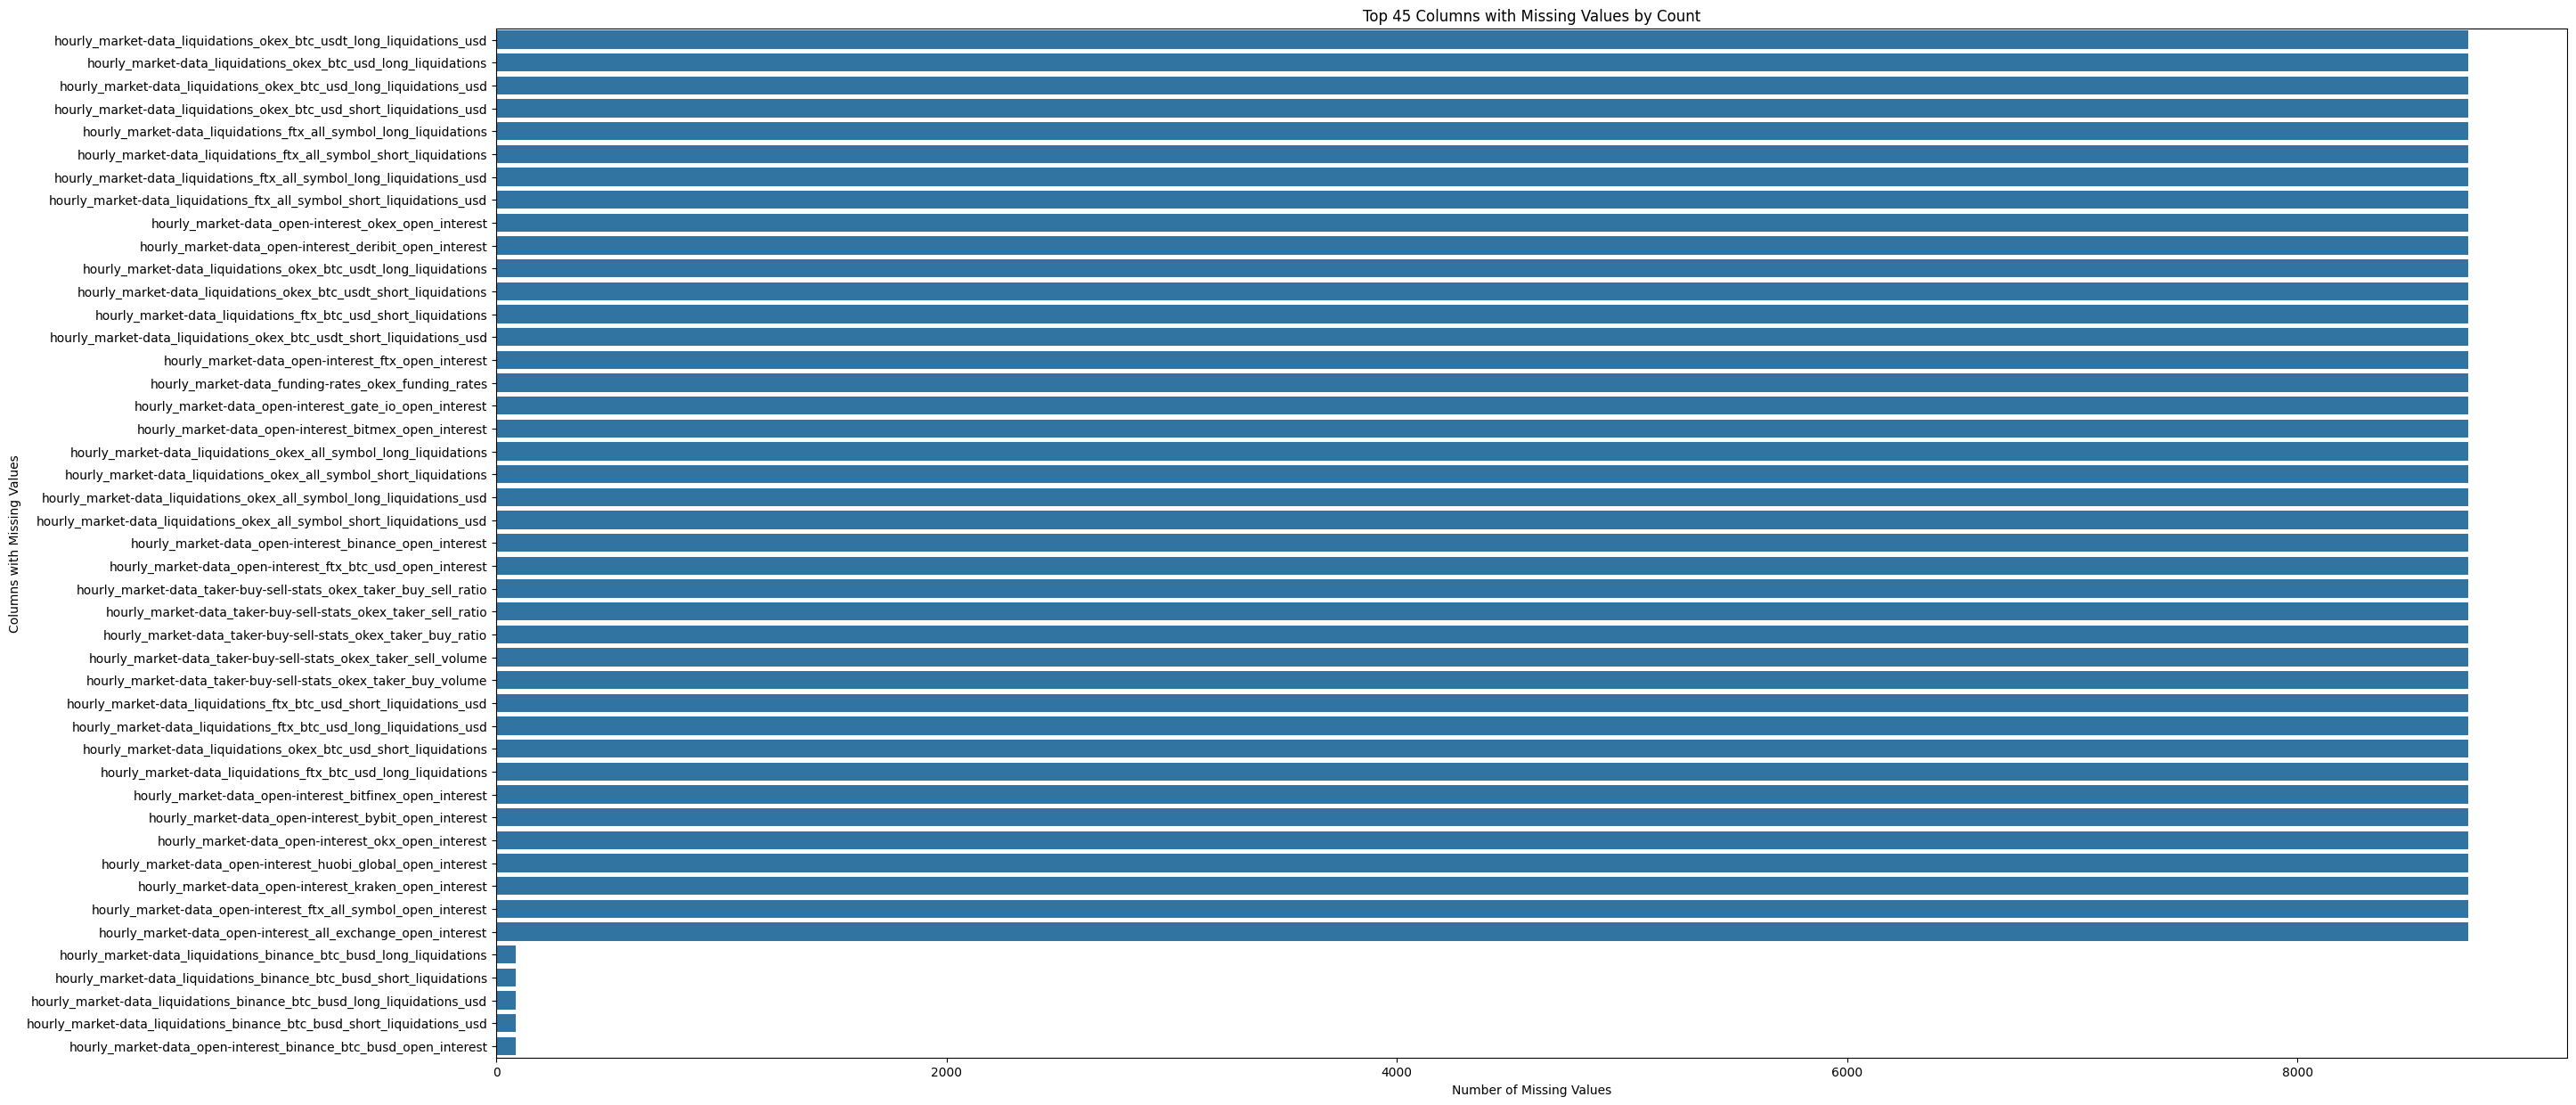

In [5]:
# 결측치 개수 상위 45개 열만 선택
top_missing_count = missing_values.sort_values(ascending=False).head(45)

# 시각화
plt.figure(figsize=(30, 15))
sns.barplot(y=top_missing_count.index, x=top_missing_count.values, orient='h')
plt.xlabel('Number of Missing Values')
plt.ylabel('Columns with Missing Values')
plt.title('Top 45 Columns with Missing Values by Count')
plt.show()

In [6]:
# 열 선택 기준
# {exchanges|symbol}이 포함된 csv 파일에서는 all_exchange 또는 all_symbol만 가져온다.
# 그렇게 선택된 endpoint 리스트는 다음 4가지이다.
# market data에서 funding rates, liquidations, taker buy sell stats, open interest
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",

    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",

    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",

    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
    
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",

    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close": "close",
    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume": "volume",
    
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "taker_buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "taker_sell_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "taker_buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "taker_sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "taker_buy_sell_ratio",

    "hourly_network-data_addresses-count_addresses_count_active": "addresses_count_active",
    "hourly_network-data_addresses-count_addresses_count_sender": "addresses_count_sender",
    "hourly_network-data_addresses-count_addresses_count_receiver": "addresses_count_receiver",

    "hourly_network-data_block-bytes_block_bytes": "block_bytes",

    "hourly_network-data_block-count_block_count": "block_count",
    
    "hourly_network-data_block-interval_block_interval": "block_interval",

    "hourly_network-data_blockreward_blockreward": "blockreward",
    "hourly_network-data_blockreward_blockreward_usd": "blockreward_usd",
    
    "hourly_network-data_difficulty_difficulty": "difficulty",

    "hourly_network-data_fees_fees_block_mean": "fees_block_mean",
    "hourly_network-data_fees_fees_block_mean_usd": "fees_block_mean_usd",
    "hourly_network-data_fees_fees_total": "fees_total",
    "hourly_network-data_fees_fees_total_usd": "fees_total_usd",
    "hourly_network-data_fees_fees_reward_percent": "fees_reward_percent",

    "hourly_network-data_fees-transaction_fees_transaction_mean": "fees_transaction_mean",
    "hourly_network-data_fees-transaction_fees_transaction_mean_usd": "fees_transaction_mean_usd",
    "hourly_network-data_fees-transaction_fees_transaction_median": "fees_transaction_median",
    "hourly_network-data_fees-transaction_fees_transaction_median_usd": "fees_transaction_median_usd",

    "hourly_network-data_hashrate_hashrate": "hashrate",

    "hourly_network-data_supply_supply_total": "supply_total",
    "hourly_network-data_supply_supply_new": "supply_new",

    "hourly_network-data_tokens-transferred_tokens_transferred_total": "tokens_transferred_total",
    "hourly_network-data_tokens-transferred_tokens_transferred_mean": "tokens_transferred_mean",
    "hourly_network-data_tokens-transferred_tokens_transferred_median": "tokens_transferred_median",

    "hourly_network-data_transactions-count_transactions_count_total": "transactions_count_total",
    "hourly_network-data_transactions-count_transactions_count_mean": "transactions_count_mean",

    "hourly_network-data_utxo-count_utxo_count": "utxo_count",
    
    "hourly_network-data_velocity_velocity_supply_total": "velocity_supply_total"
}
# 추출 후 단순화를 위해 rename
eda_df = eda_df[cols_dict.keys()].rename(cols_dict, axis=1)

In [7]:
eda_df.isnull().sum()

ID                              0
target                          0
coinbase_premium_gap            5
coinbase_premium_index          5
funding_rates                   0
long_liquidations               0
short_liquidations              0
long_liquidations_usd           0
short_liquidations_usd          0
open_interest                   0
close                           0
volume                          0
taker_buy_volume                0
taker_sell_volume               0
taker_buy_ratio                 0
taker_sell_ratio                0
taker_buy_sell_ratio            0
addresses_count_active          0
addresses_count_sender          0
addresses_count_receiver        0
block_bytes                    19
block_count                     0
block_interval                 19
blockreward                     0
blockreward_usd                 0
difficulty                     19
fees_block_mean                19
fees_block_mean_usd            19
fees_total                      0
fees_total_usd

In [8]:
missing_values = eda_df.isnull().sum()

# 누락된 값의 백분율 계산
missing_percentage = (missing_values / len(eda_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
pd.set_option('display.max_columns', None)
sorted_missing_percentage

block_interval                 0.216895
tokens_transferred_mean        0.216895
fees_block_mean                0.216895
fees_block_mean_usd            0.216895
block_bytes                    0.216895
fees_reward_percent            0.216895
fees_transaction_mean          0.216895
fees_transaction_mean_usd      0.216895
difficulty                     0.216895
transactions_count_mean        0.216895
coinbase_premium_index         0.057078
coinbase_premium_gap           0.057078
tokens_transferred_total       0.000000
supply_new                     0.000000
supply_total                   0.000000
blockreward_usd                0.000000
fees_transaction_median_usd    0.000000
fees_transaction_median        0.000000
tokens_transferred_median      0.000000
transactions_count_total       0.000000
fees_total_usd                 0.000000
fees_total                     0.000000
utxo_count                     0.000000
hashrate                       0.000000
ID                             0.000000


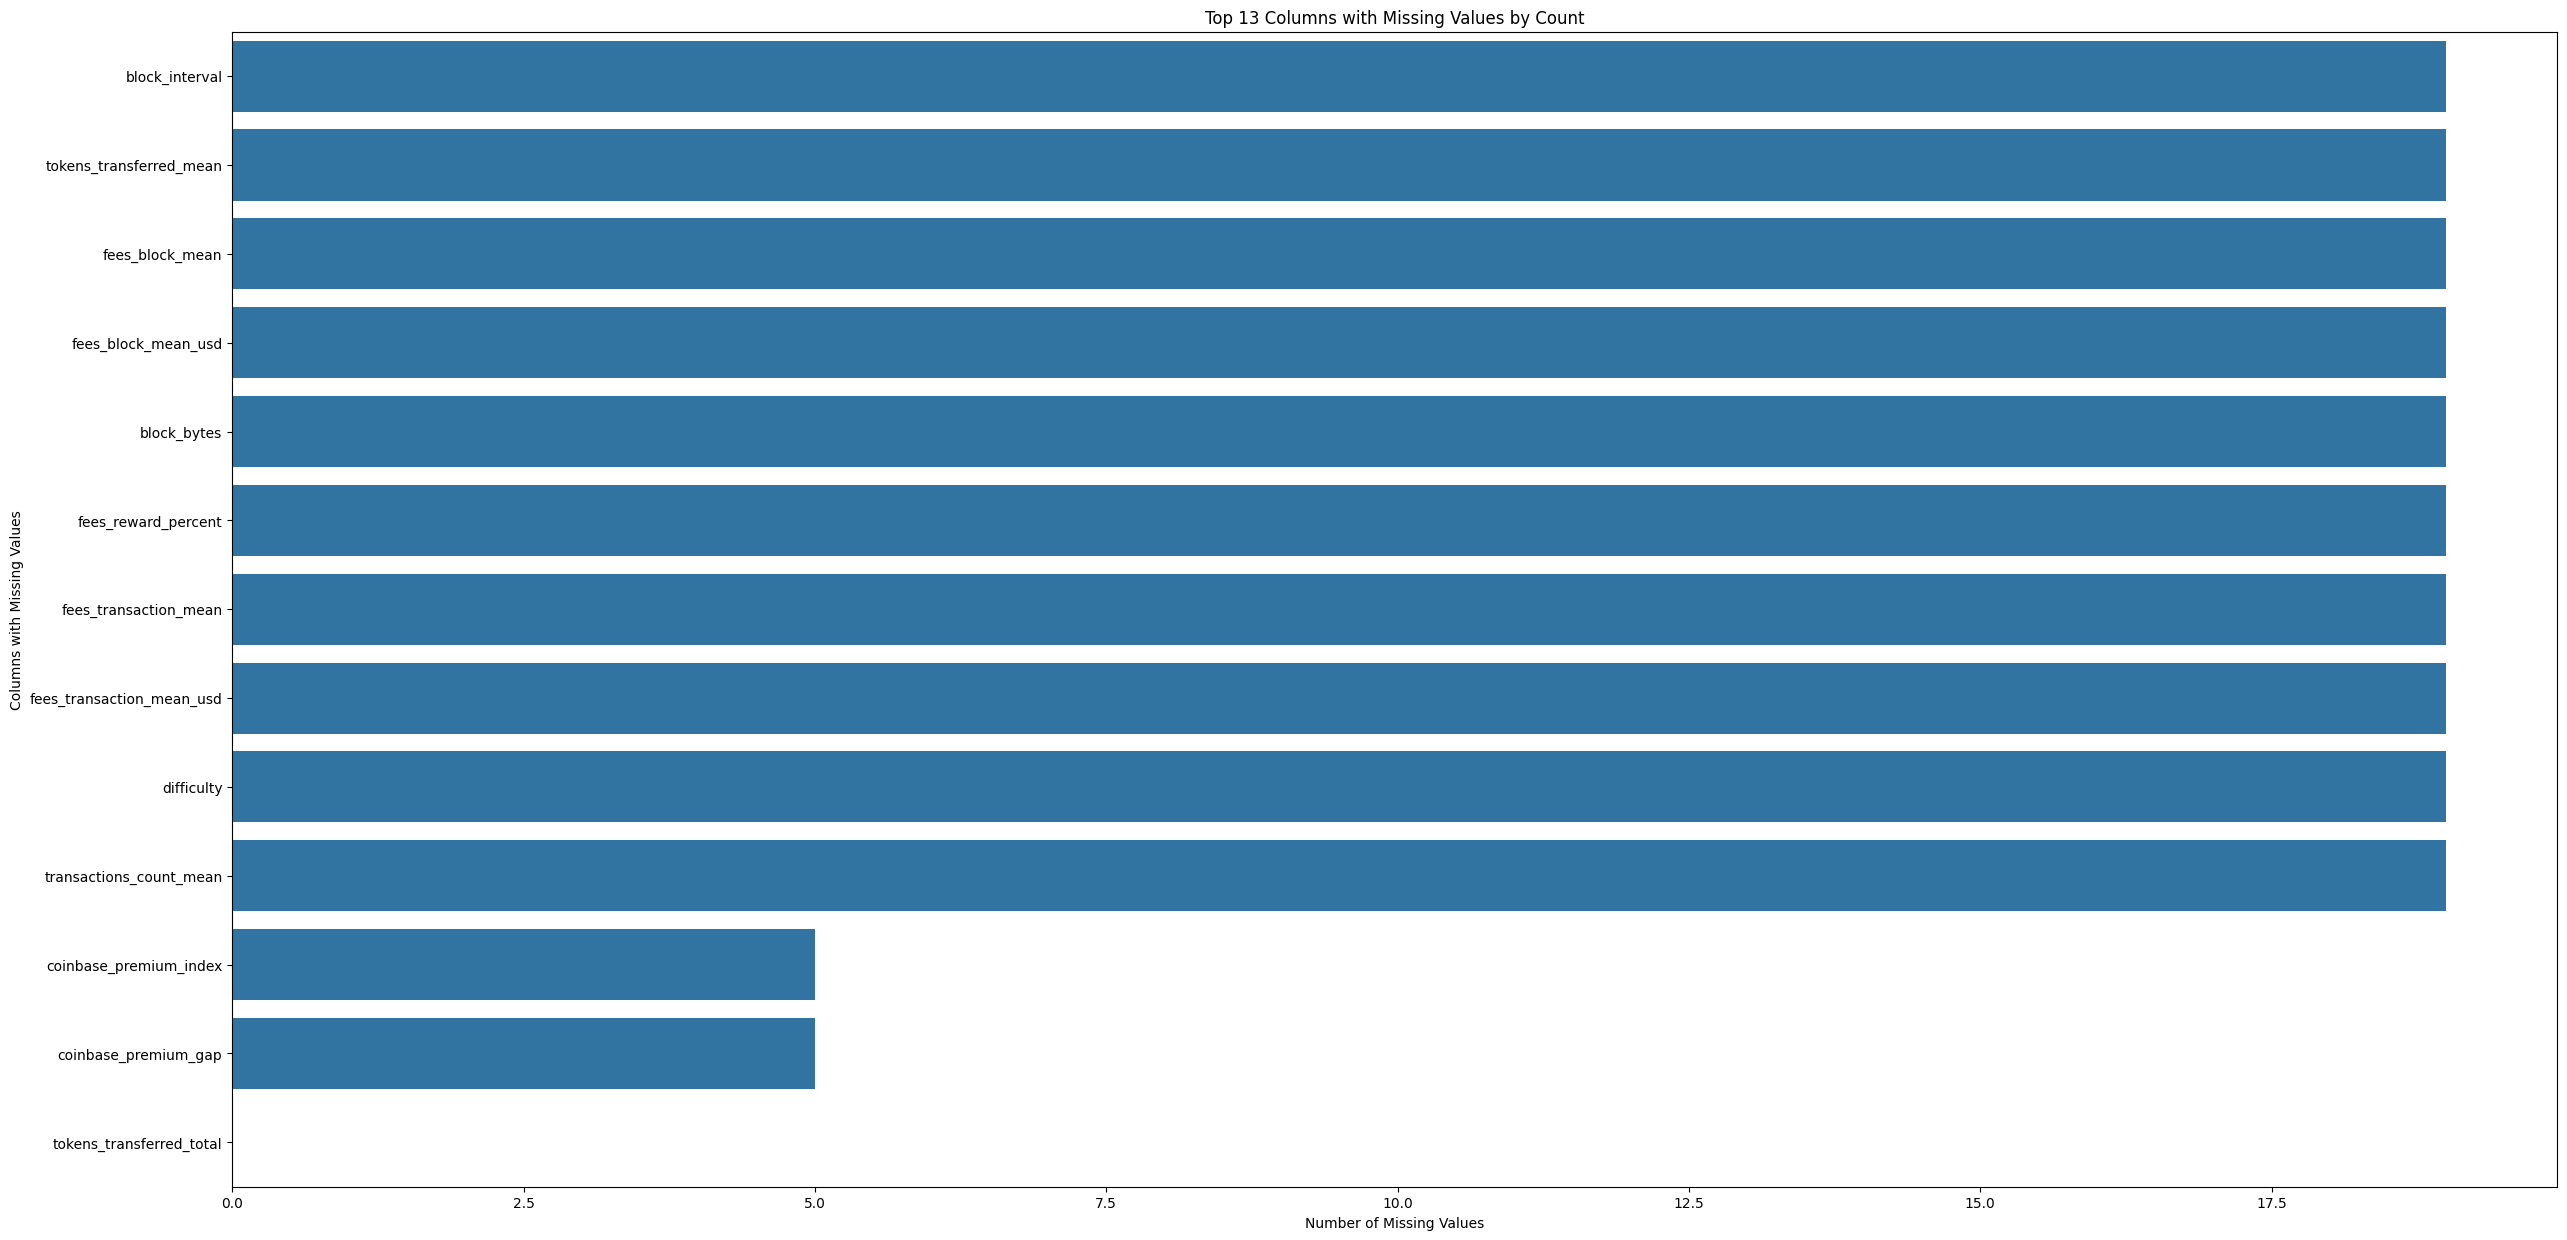

In [9]:
# 결측치 개수 상위 13개 열만 선택
top_missing_count = missing_values.sort_values(ascending=False).head(13)

# 시각화
plt.figure(figsize=(30, 15))
sns.barplot(y=top_missing_count.index, x=top_missing_count.values, orient='h')
plt.xlabel('Number of Missing Values')
plt.ylabel('Columns with Missing Values')
plt.title('Top 13 Columns with Missing Values by Count')
plt.show()

### 19개의 결측치를 가진 것은 모두 Network Data(10개)
### 5개의 결측치를 가진 것은 Market Data(2개)

## Correlations

In [10]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 0 to 8759
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           8760 non-null   object 
 1   target                       8760 non-null   float64
 2   coinbase_premium_gap         8755 non-null   float64
 3   coinbase_premium_index       8755 non-null   float64
 4   funding_rates                8760 non-null   float64
 5   long_liquidations            8760 non-null   float64
 6   short_liquidations           8760 non-null   float64
 7   long_liquidations_usd        8760 non-null   float64
 8   short_liquidations_usd       8760 non-null   float64
 9   open_interest                8760 non-null   float64
 10  close                        8760 non-null   float64
 11  volume                       8760 non-null   float64
 12  taker_buy_volume             8760 non-null   float64
 13  taker_sell_volume      

In [11]:
eda_df.to_csv("eda_df.csv")

In [12]:
corr_df = eda_df.drop(columns='ID', inplace=False).corr()

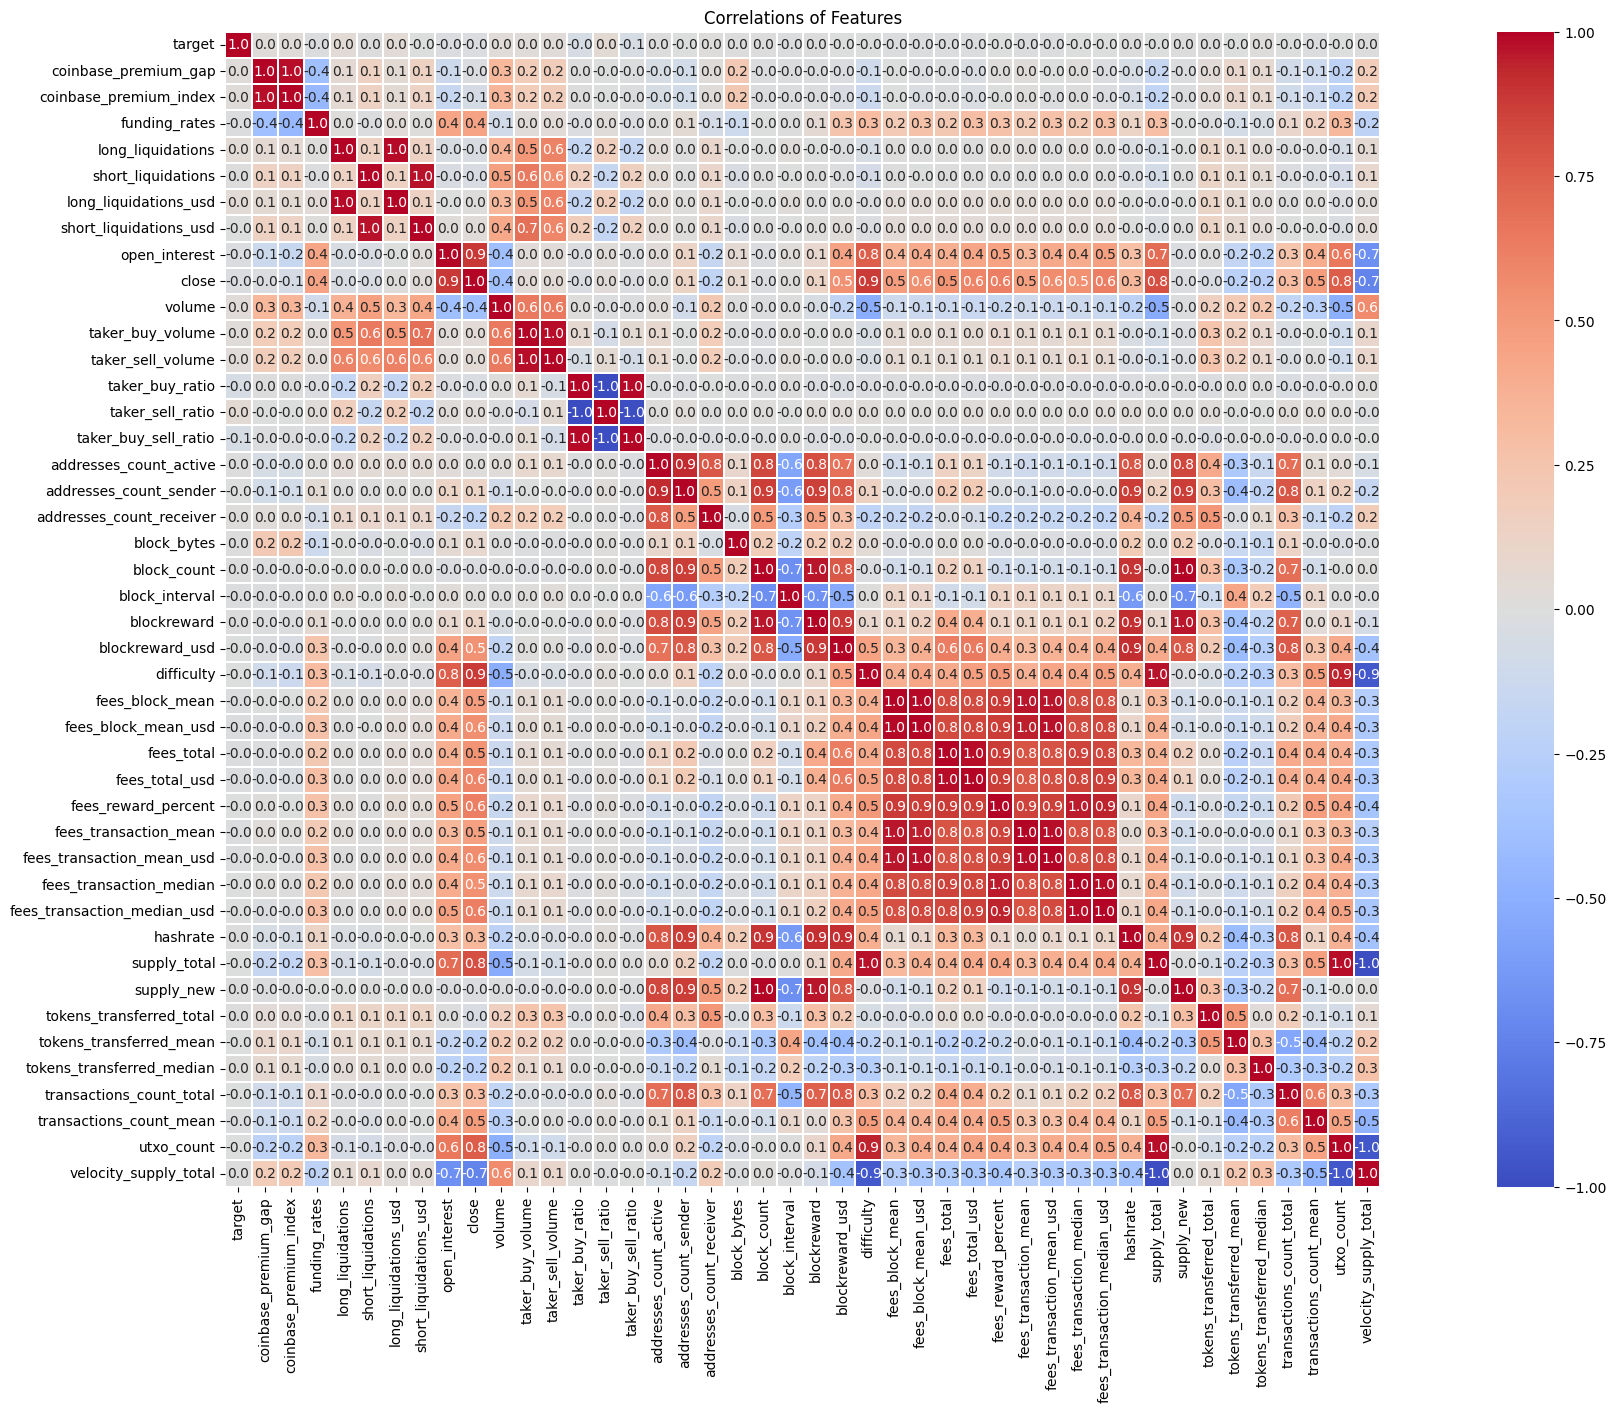

In [13]:
# mask = np.zeros_like(corr_df)
# mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(30, 15))
sns.heatmap(corr_df, cmap='coolwarm', annot=True, fmt='.1f', linewidth=0.2, square=True)
plt.title('Correlations of Features')
plt.show()

In [14]:
print(corr_df.columns)

Index(['target', 'coinbase_premium_gap', 'coinbase_premium_index',
       'funding_rates', 'long_liquidations', 'short_liquidations',
       'long_liquidations_usd', 'short_liquidations_usd', 'open_interest',
       'close', 'volume', 'taker_buy_volume', 'taker_sell_volume',
       'taker_buy_ratio', 'taker_sell_ratio', 'taker_buy_sell_ratio',
       'addresses_count_active', 'addresses_count_sender',
       'addresses_count_receiver', 'block_bytes', 'block_count',
       'block_interval', 'blockreward', 'blockreward_usd', 'difficulty',
       'fees_block_mean', 'fees_block_mean_usd', 'fees_total',
       'fees_total_usd', 'fees_reward_percent', 'fees_transaction_mean',
       'fees_transaction_mean_usd', 'fees_transaction_median',
       'fees_transaction_median_usd', 'hashrate', 'supply_total', 'supply_new',
       'tokens_transferred_total', 'tokens_transferred_mean',
       'tokens_transferred_median', 'transactions_count_total',
       'transactions_count_mean', 'utxo_count', 'vel

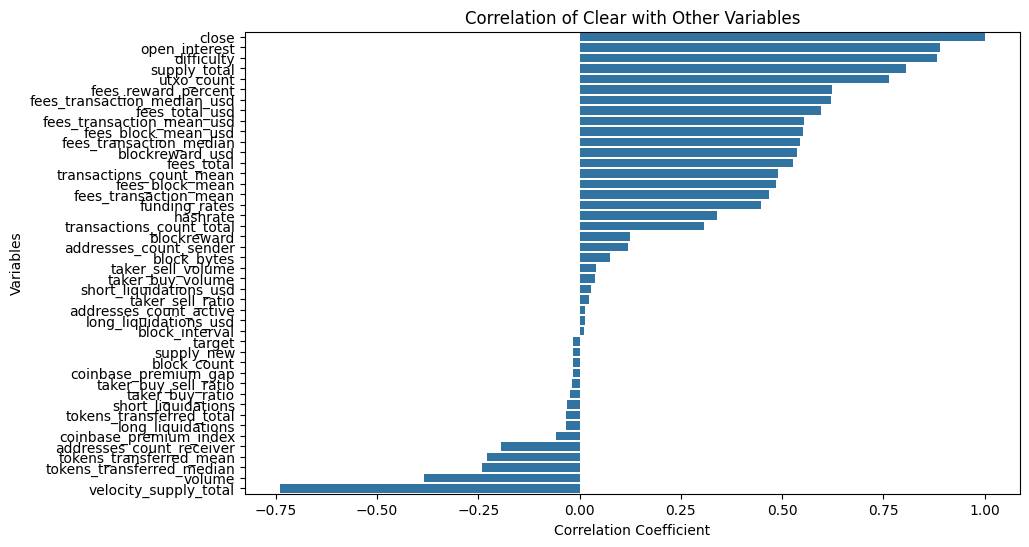

In [15]:
close_correlations = corr_df['close'].sort_values(ascending=False)

#시각화
plt.figure(figsize=(10,6))
sns.barplot(y=close_correlations.index, x=close_correlations.values, orient='h')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Variables')
plt.title('Correlation of Clear with Other Variables')
plt.show()

## Line plot

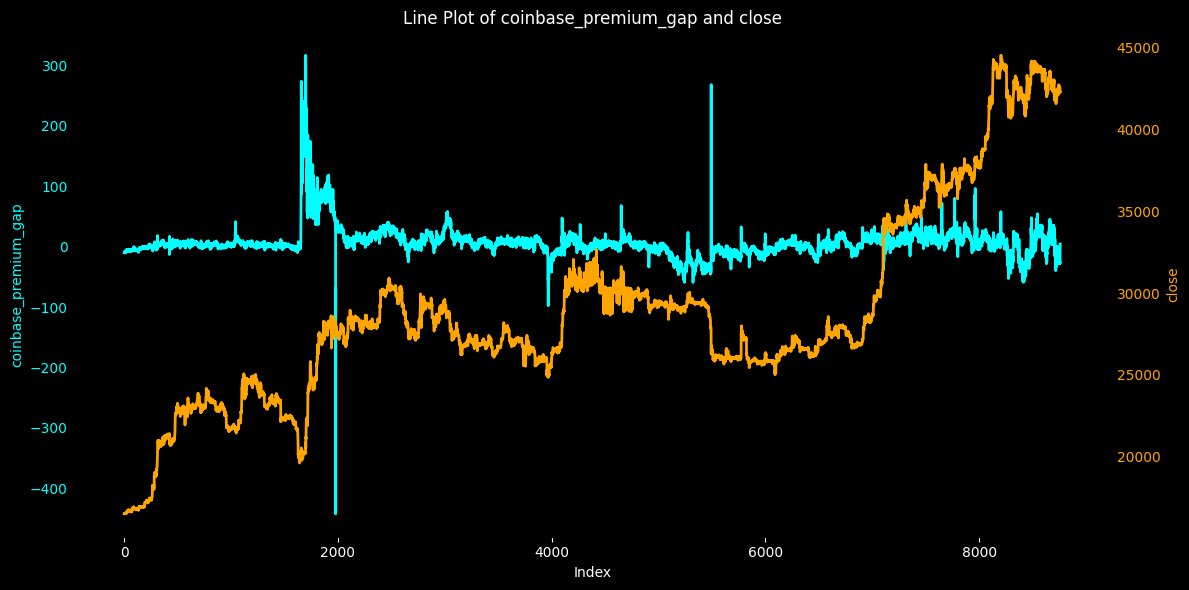

In [16]:
# coinbase_premium_gap & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'coinbase_premium_gap'을 주 Y축에 그리기
ax1.plot(eda_df['coinbase_premium_gap'], label='coinbase_premium_gap', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('coinbase_premium_gap', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of coinbase_premium_gap and close', color='white')
fig.tight_layout()
plt.show()


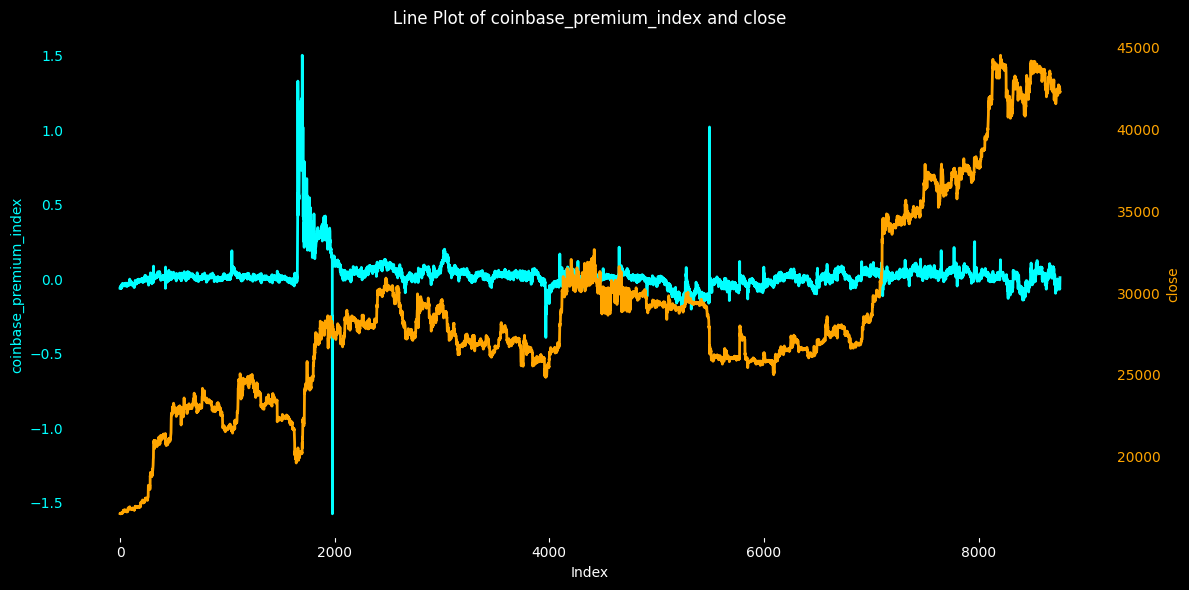

In [17]:
# coinbase_premium_index & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'coinbase_premium_index'을 주 Y축에 그리기
ax1.plot(eda_df['coinbase_premium_index'], label='coinbase_premium_index', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('coinbase_premium_index', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of coinbase_premium_index and close', color='white')
fig.tight_layout()
plt.show()


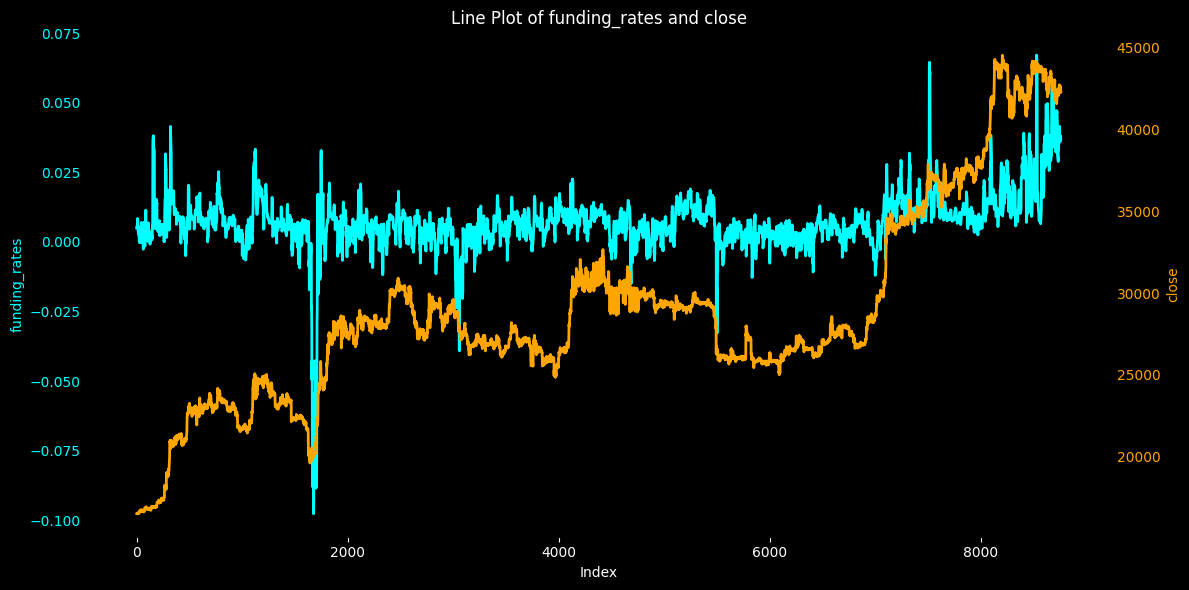

In [18]:
# funding_rates & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'funding_rates'을 주 Y축에 그리기
ax1.plot(eda_df['funding_rates'], label='funding_rates', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('funding_rates', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of funding_rates and close', color='white')
fig.tight_layout()
plt.show()


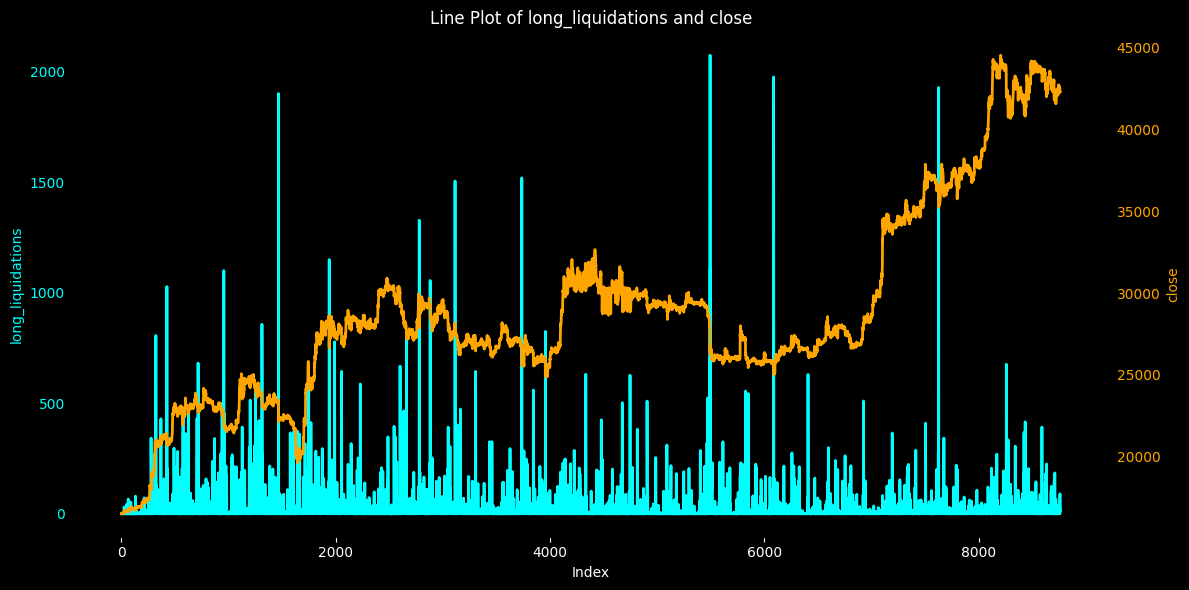

In [19]:
# long_liquidations & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'long_liquidations'을 주 Y축에 그리기
ax1.plot(eda_df['long_liquidations'], label='long_liquidations', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('long_liquidations', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of long_liquidations and close', color='white')
fig.tight_layout()
plt.show()


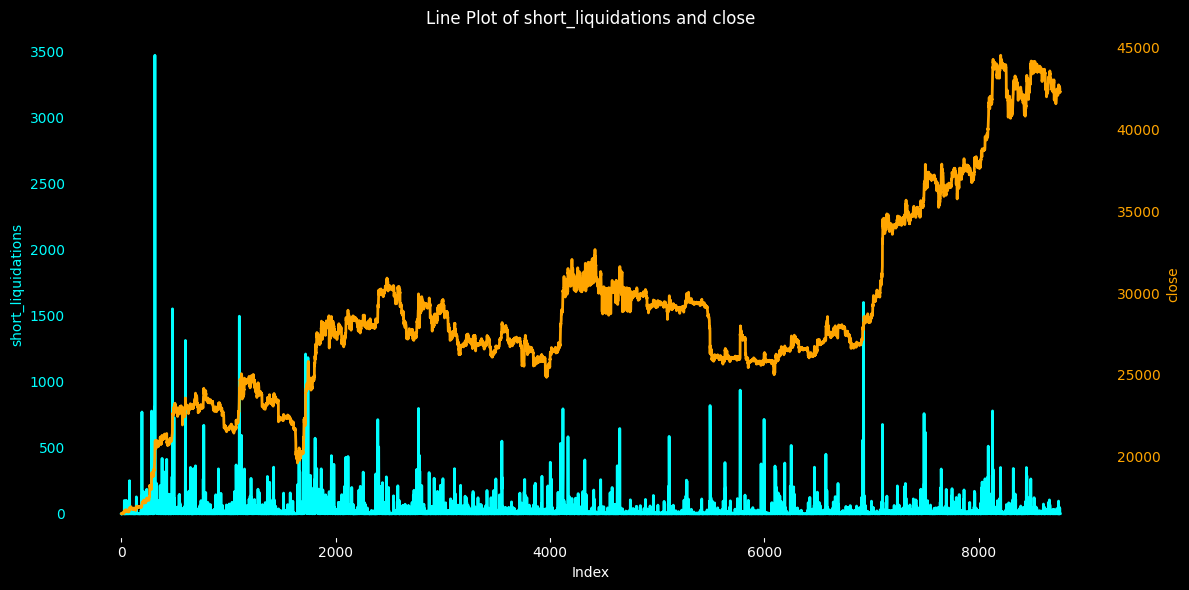

In [20]:
# short_liquidations & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'short_liquidations'을 주 Y축에 그리기
ax1.plot(eda_df['short_liquidations'], label='short_liquidations', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('short_liquidations', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of short_liquidations and close', color='white')
fig.tight_layout()
plt.show()


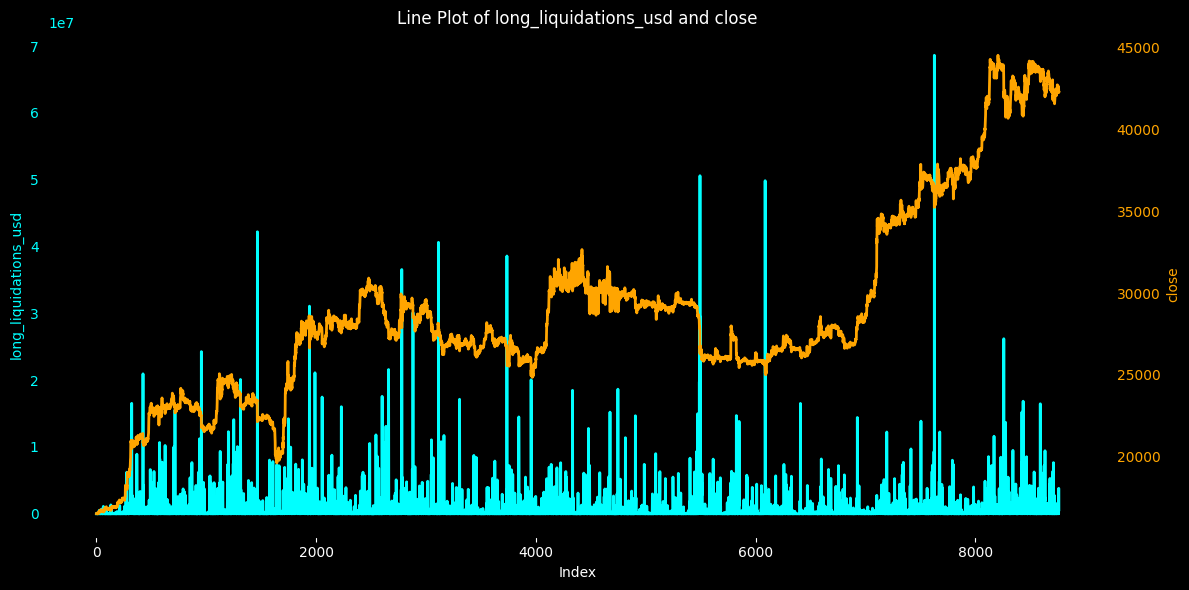

In [21]:
# long_liquidations_usd & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'long_liquidations_usd'을 주 Y축에 그리기
ax1.plot(eda_df['long_liquidations_usd'], label='long_liquidations_usd', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('long_liquidations_usd', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of long_liquidations_usd and close', color='white')
fig.tight_layout()
plt.show()


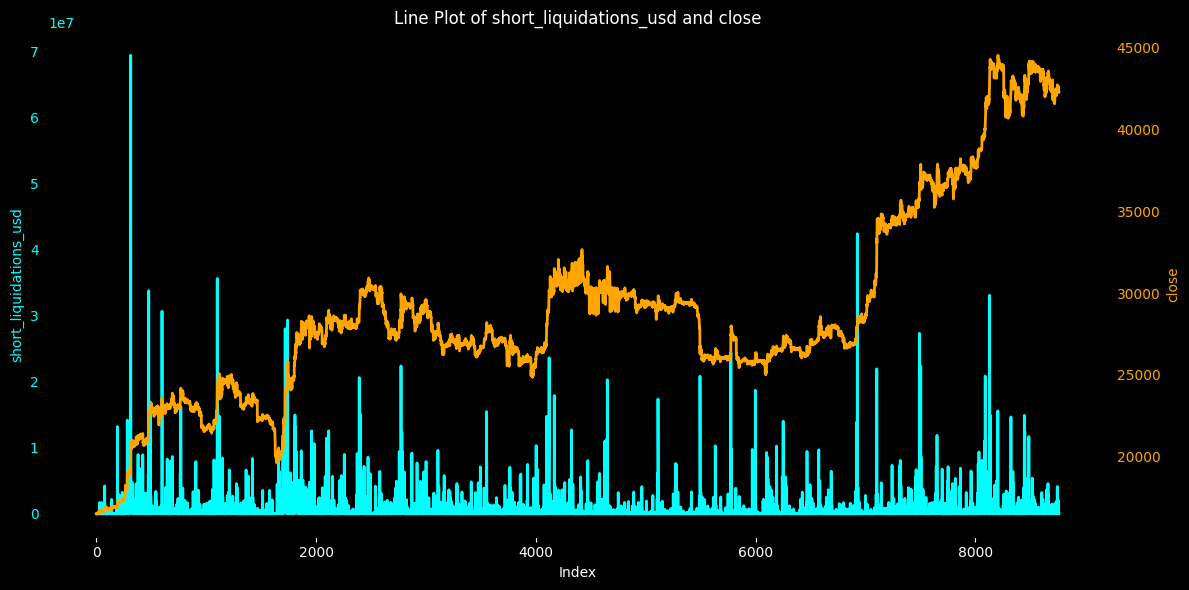

In [22]:
# short_liquidations_usd & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'short_liquidations_usd'을 주 Y축에 그리기
ax1.plot(eda_df['short_liquidations_usd'], label='short_liquidations_usd', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('short_liquidations_usd', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of short_liquidations_usd and close', color='white')
fig.tight_layout()
plt.show()


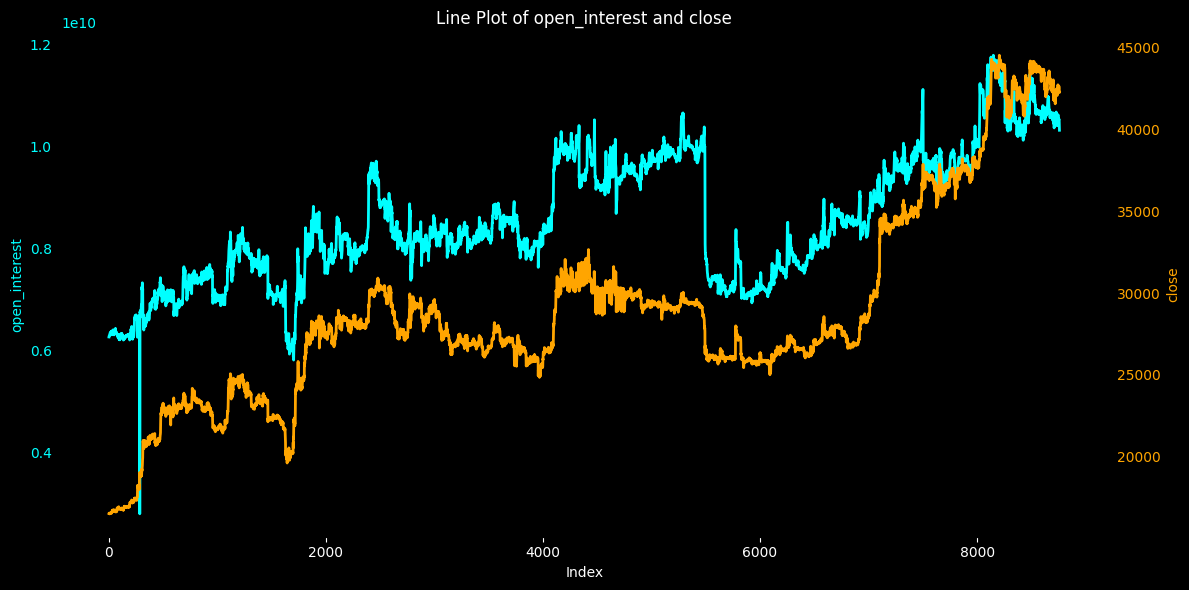

In [23]:
# open_interest & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'open_interest'을 주 Y축에 그리기
ax1.plot(eda_df['open_interest'], label='open_interest', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('open_interest', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of open_interest and close', color='white')
fig.tight_layout()
plt.show()


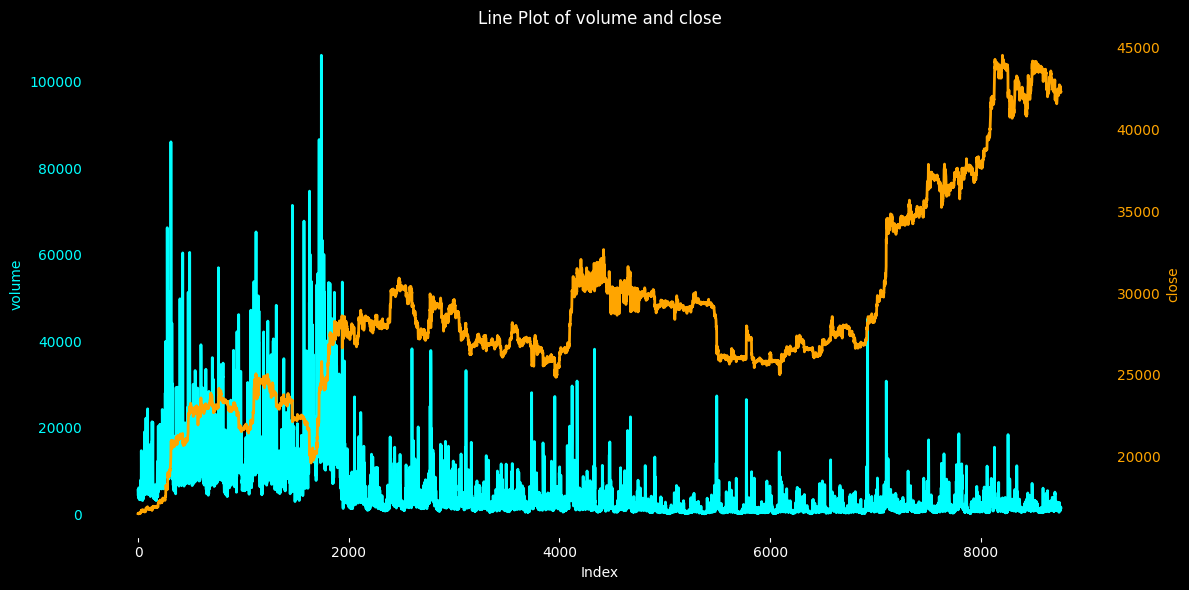

In [24]:
# volume & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'volume'을 주 Y축에 그리기
ax1.plot(eda_df['volume'], label='volume', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('volume', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of volume and close', color='white')
fig.tight_layout()
plt.show()


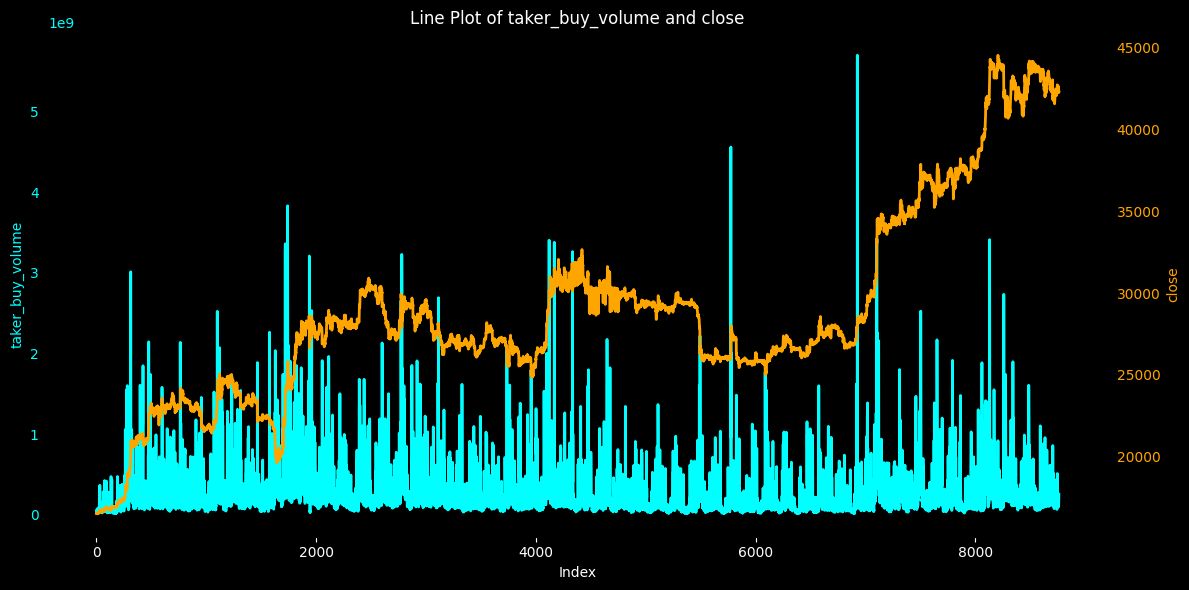

In [25]:
# taker_buy_volume & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'taker_buy_volume'을 주 Y축에 그리기
ax1.plot(eda_df['taker_buy_volume'], label='taker_buy_volume', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('taker_buy_volume', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of taker_buy_volume and close', color='white')
fig.tight_layout()
plt.show()


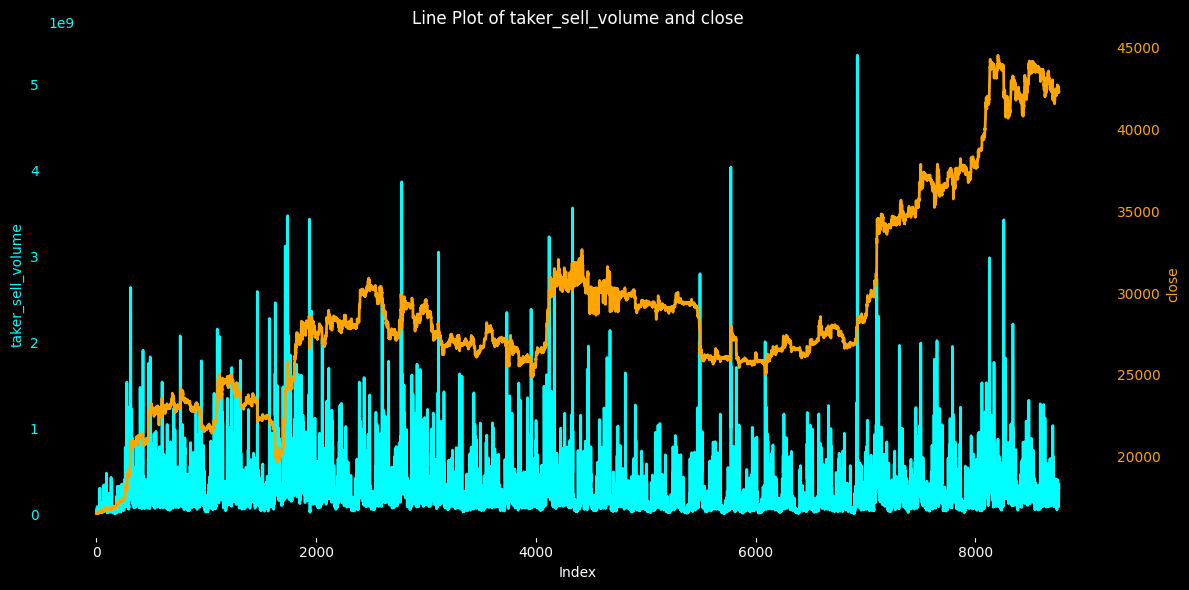

In [26]:
# taker_sell_volume & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'taker_sell_volume'을 주 Y축에 그리기
ax1.plot(eda_df['taker_sell_volume'], label='taker_sell_volume', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('taker_sell_volume', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of taker_sell_volume and close', color='white')
fig.tight_layout()
plt.show()


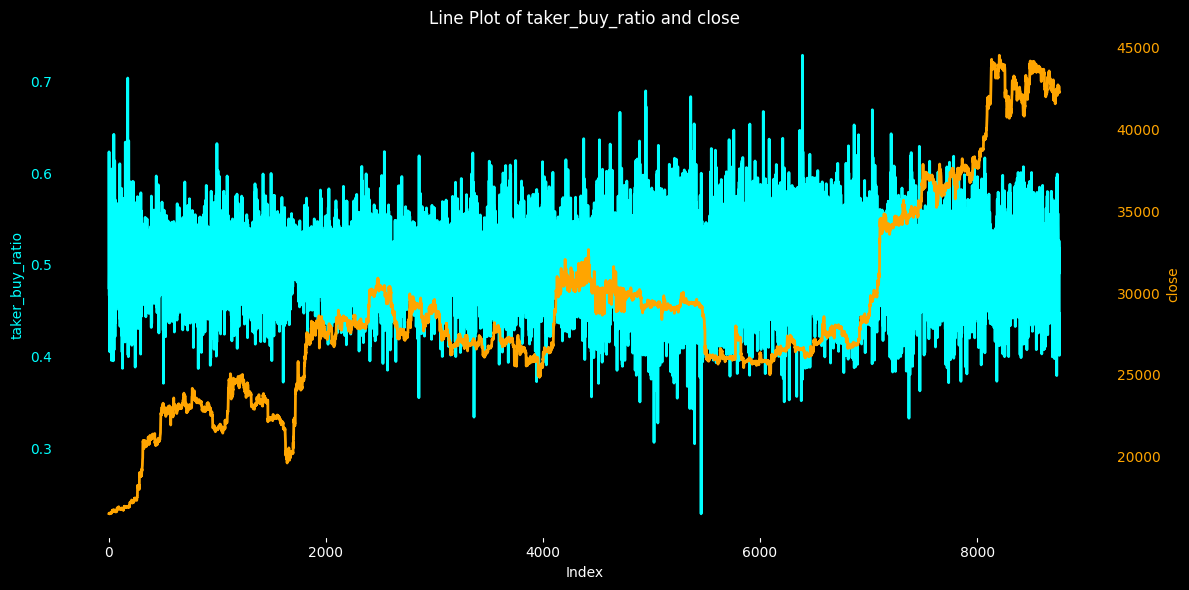

In [27]:
# taker_buy_ratio & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'taker_buy_ratio'을 주 Y축에 그리기
ax1.plot(eda_df['taker_buy_ratio'], label='taker_buy_ratio', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('taker_buy_ratio', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of taker_buy_ratio and close', color='white')
fig.tight_layout()
plt.show()


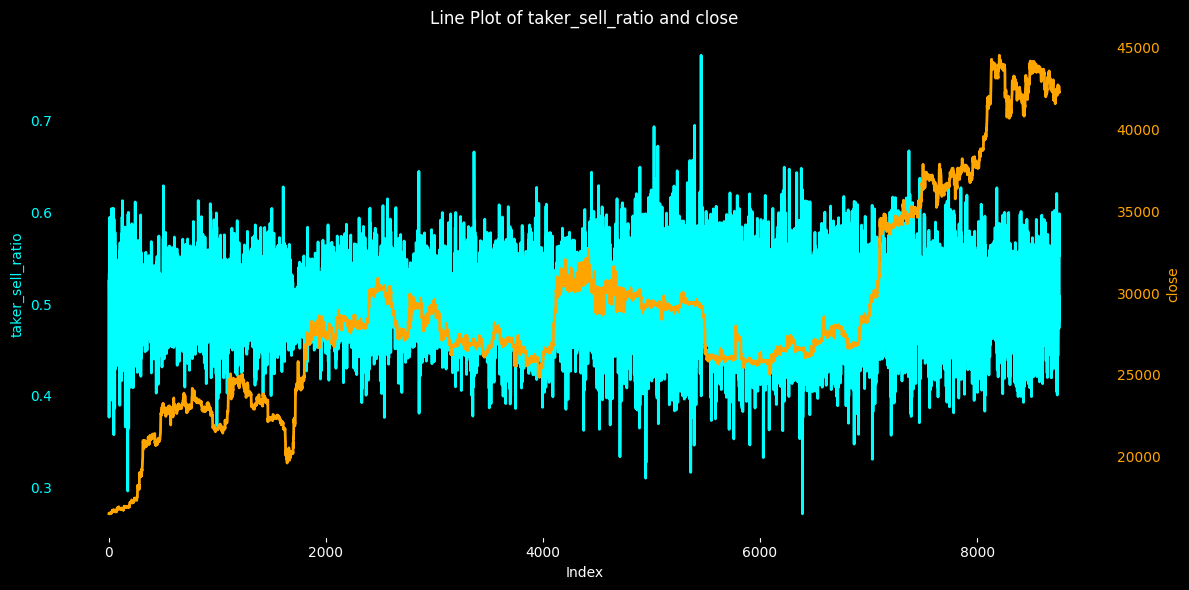

In [28]:
# taker_sell_ratio & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'taker_sell_ratio'을 주 Y축에 그리기
ax1.plot(eda_df['taker_sell_ratio'], label='taker_sell_ratio', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('taker_sell_ratio', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of taker_sell_ratio and close', color='white')
fig.tight_layout()
plt.show()


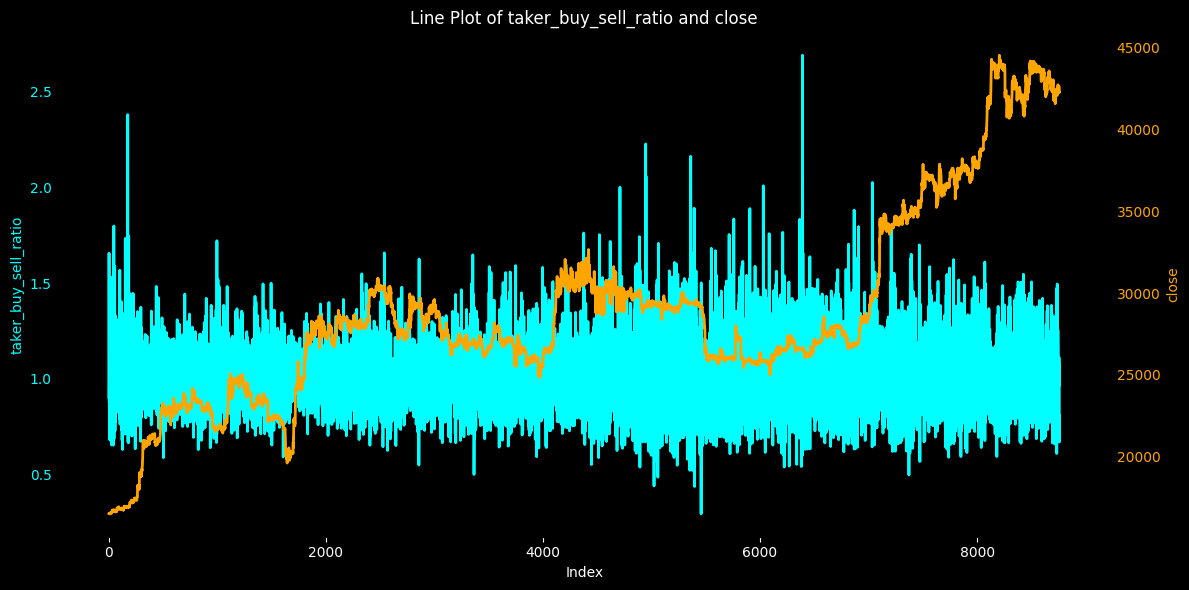

In [29]:
# taker_buy_sell_ratio & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'taker_buy_sell_ratio'을 주 Y축에 그리기
ax1.plot(eda_df['taker_buy_sell_ratio'], label='taker_buy_sell_ratio', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('taker_buy_sell_ratio', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of taker_buy_sell_ratio and close', color='white')
fig.tight_layout()
plt.show()


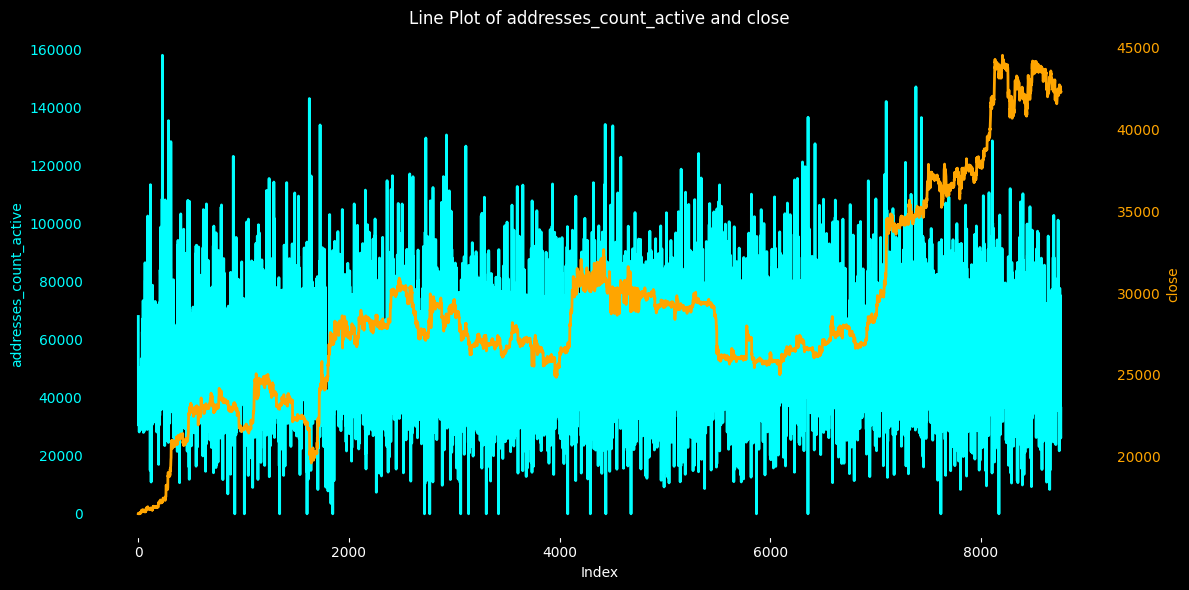

In [30]:
# addresses_count_active & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'addresses_count_active'을 주 Y축에 그리기
ax1.plot(eda_df['addresses_count_active'], label='addresses_count_active', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('addresses_count_active', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of addresses_count_active and close', color='white')
fig.tight_layout()
plt.show()


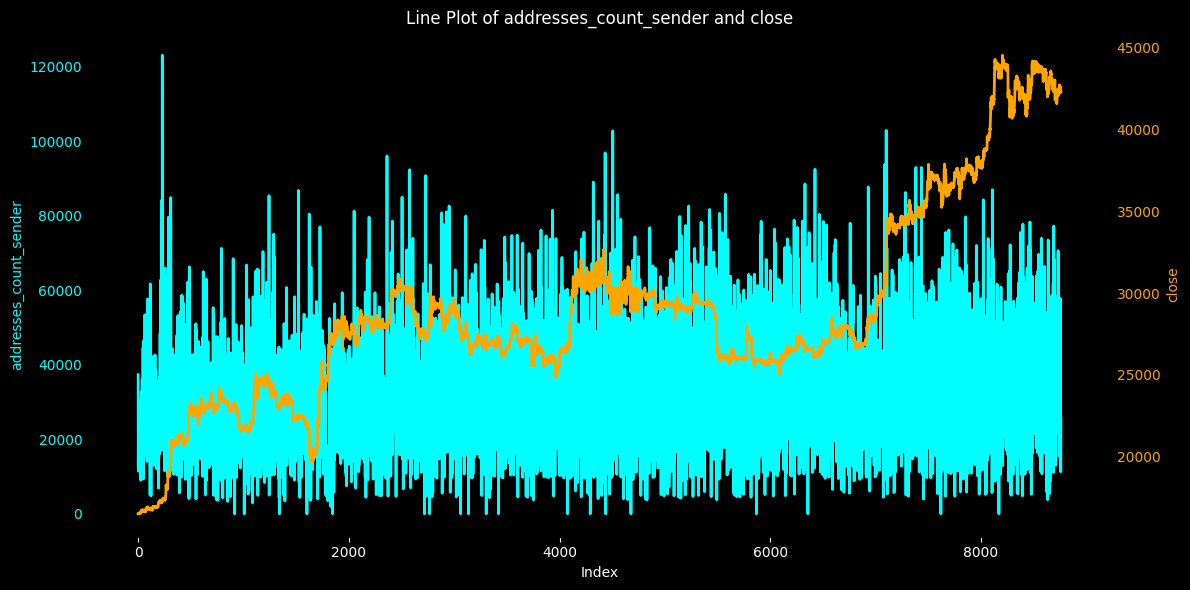

In [31]:
# addresses_count_sender & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'addresses_count_sender'을 주 Y축에 그리기
ax1.plot(eda_df['addresses_count_sender'], label='addresses_count_sender', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('addresses_count_sender', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of addresses_count_sender and close', color='white')
fig.tight_layout()
plt.show()


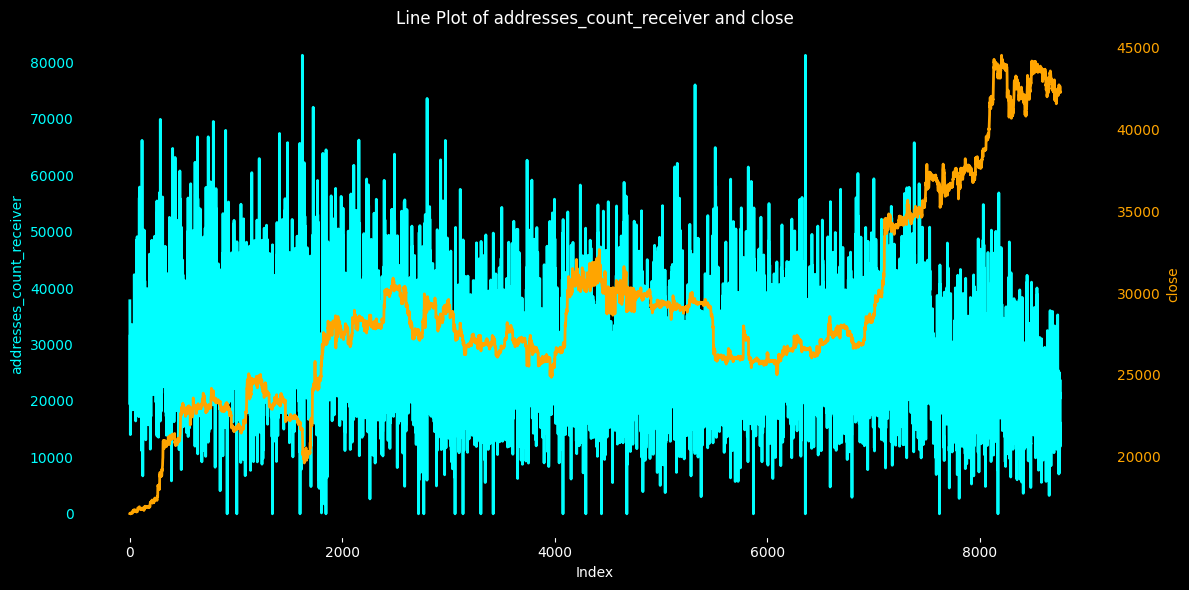

In [32]:
# addresses_count_receiver & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'addresses_count_receiver'을 주 Y축에 그리기
ax1.plot(eda_df['addresses_count_receiver'], label='addresses_count_receiver', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('addresses_count_receiver', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of addresses_count_receiver and close', color='white')
fig.tight_layout()
plt.show()


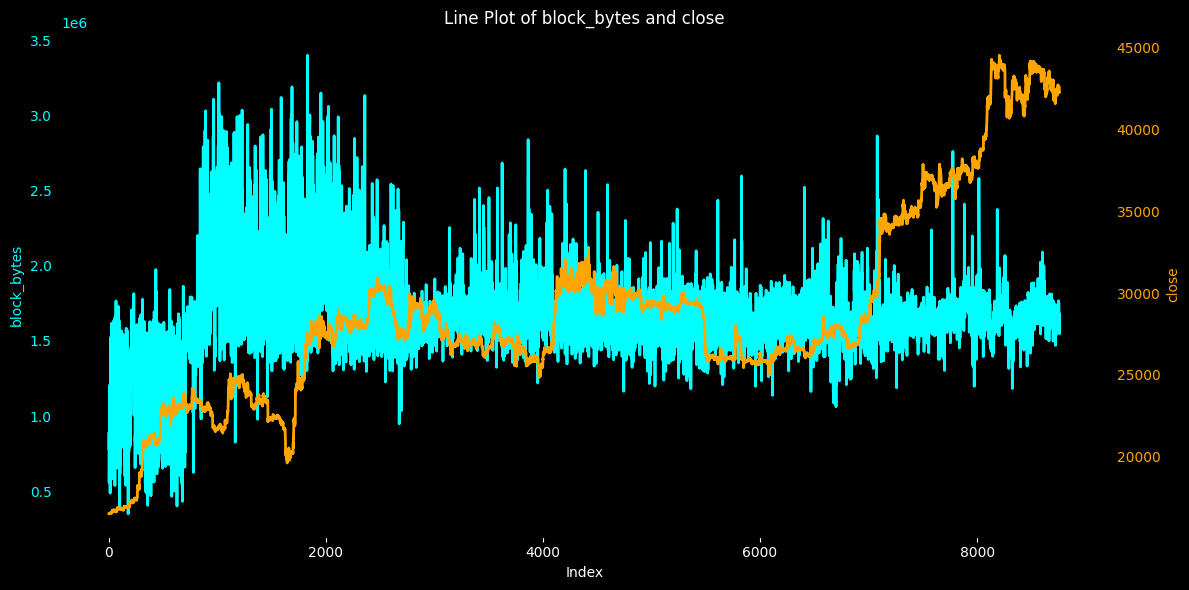

In [33]:
# block_bytes & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'block_bytes'을 주 Y축에 그리기
ax1.plot(eda_df['block_bytes'], label='block_bytes', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('block_bytes', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of block_bytes and close', color='white')
fig.tight_layout()
plt.show()


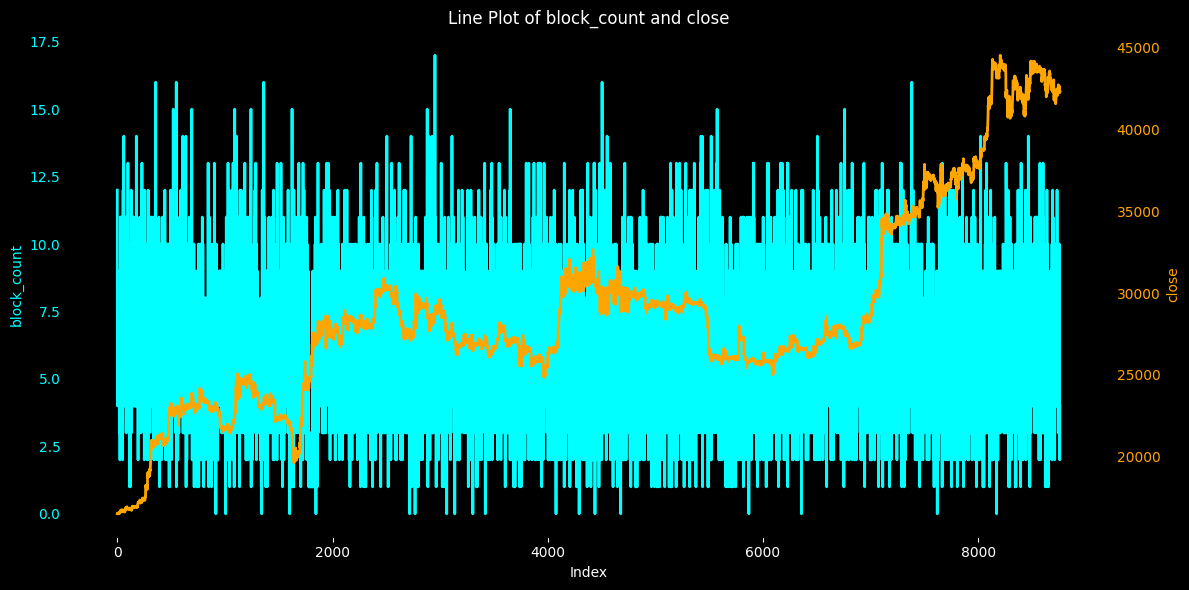

In [34]:
# block_count & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'block_count'을 주 Y축에 그리기
ax1.plot(eda_df['block_count'], label='block_count', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('block_count', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of block_count and close', color='white')
fig.tight_layout()
plt.show()


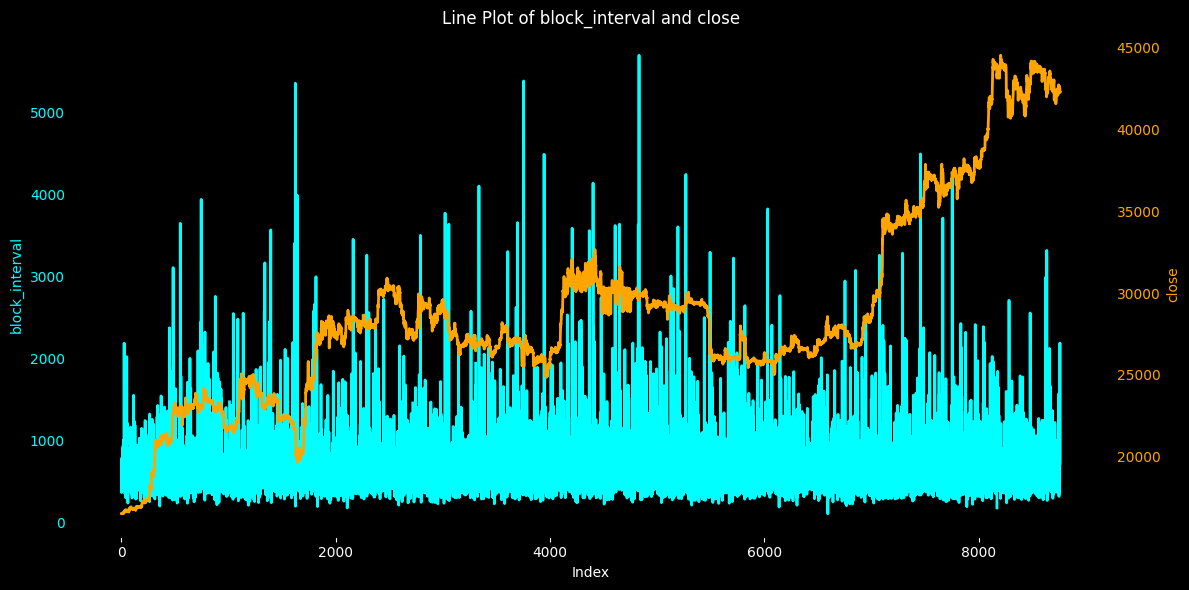

In [35]:
# block_interval & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'block_interval'을 주 Y축에 그리기
ax1.plot(eda_df['block_interval'], label='block_interval', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('block_interval', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of block_interval and close', color='white')
fig.tight_layout()
plt.show()


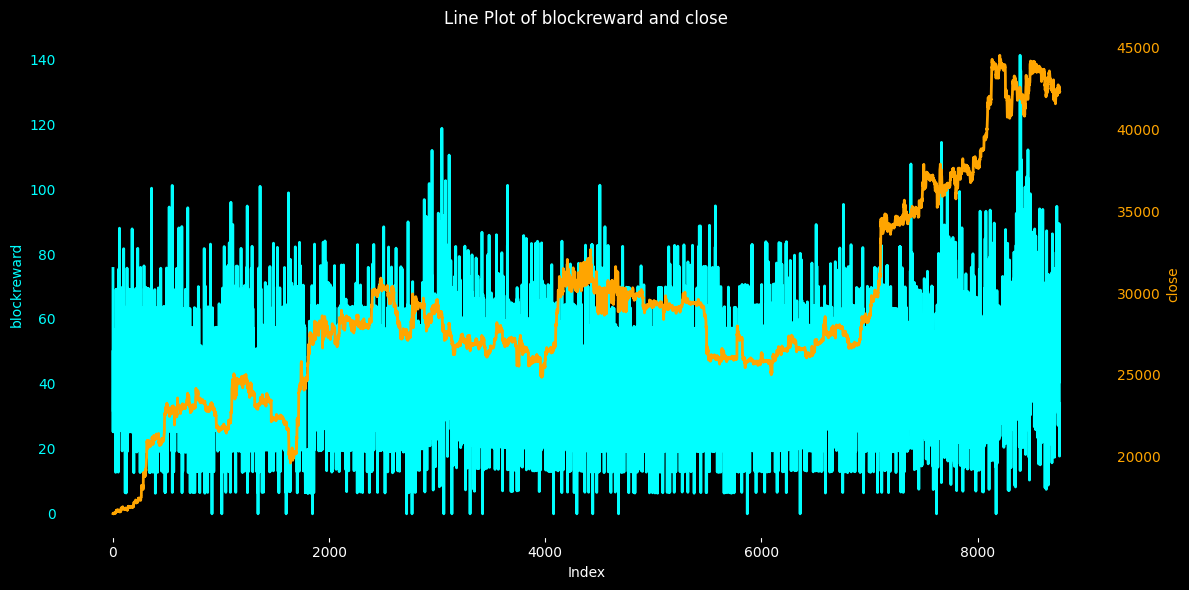

In [36]:
# blockreward & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'blockreward'을 주 Y축에 그리기
ax1.plot(eda_df['blockreward'], label='blockreward', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('blockreward', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of blockreward and close', color='white')
fig.tight_layout()
plt.show()


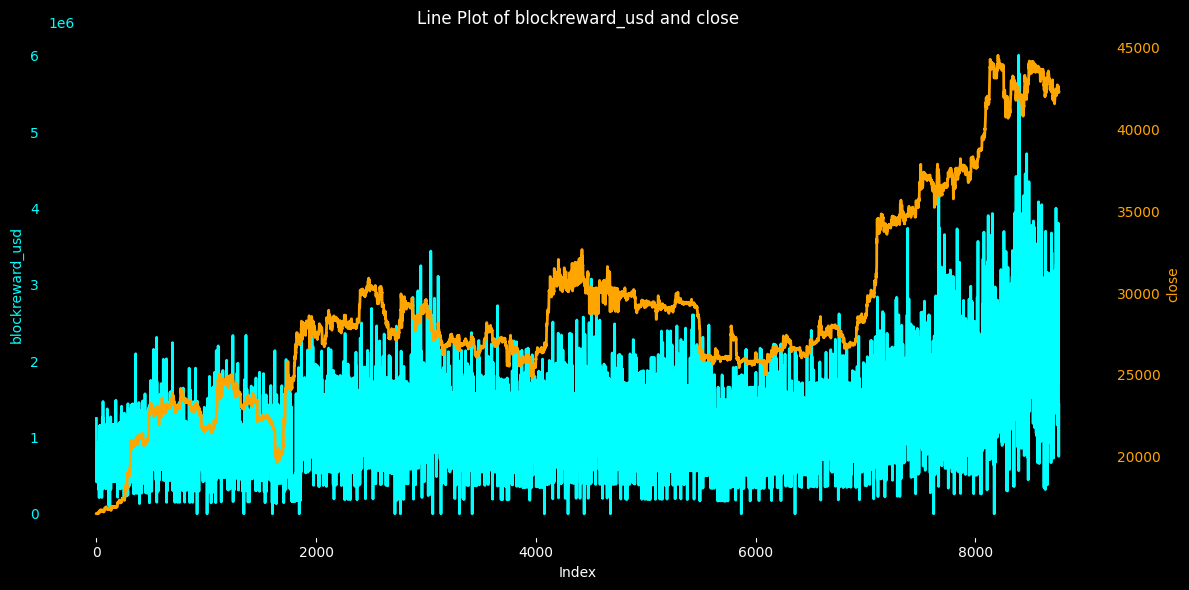

In [37]:
# blockreward_usd & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'blockreward_usd'을 주 Y축에 그리기
ax1.plot(eda_df['blockreward_usd'], label='blockreward_usd', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('blockreward_usd', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of blockreward_usd and close', color='white')
fig.tight_layout()
plt.show()


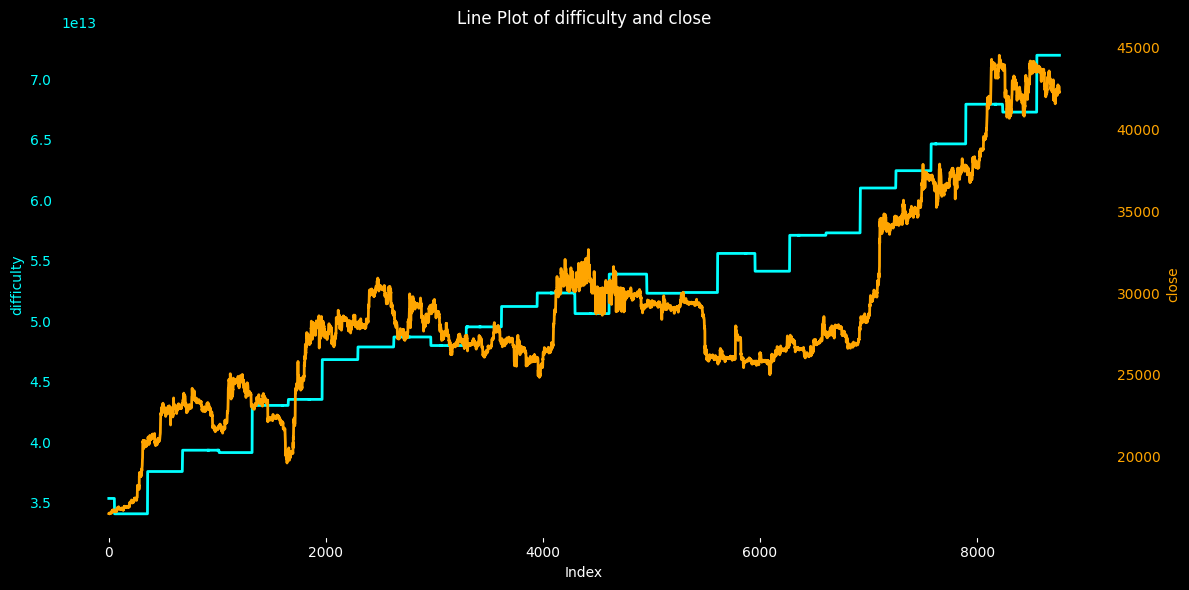

In [38]:
# difficulty & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'difficulty'을 주 Y축에 그리기
ax1.plot(eda_df['difficulty'], label='difficulty', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('difficulty', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of difficulty and close', color='white')
fig.tight_layout()
plt.show()


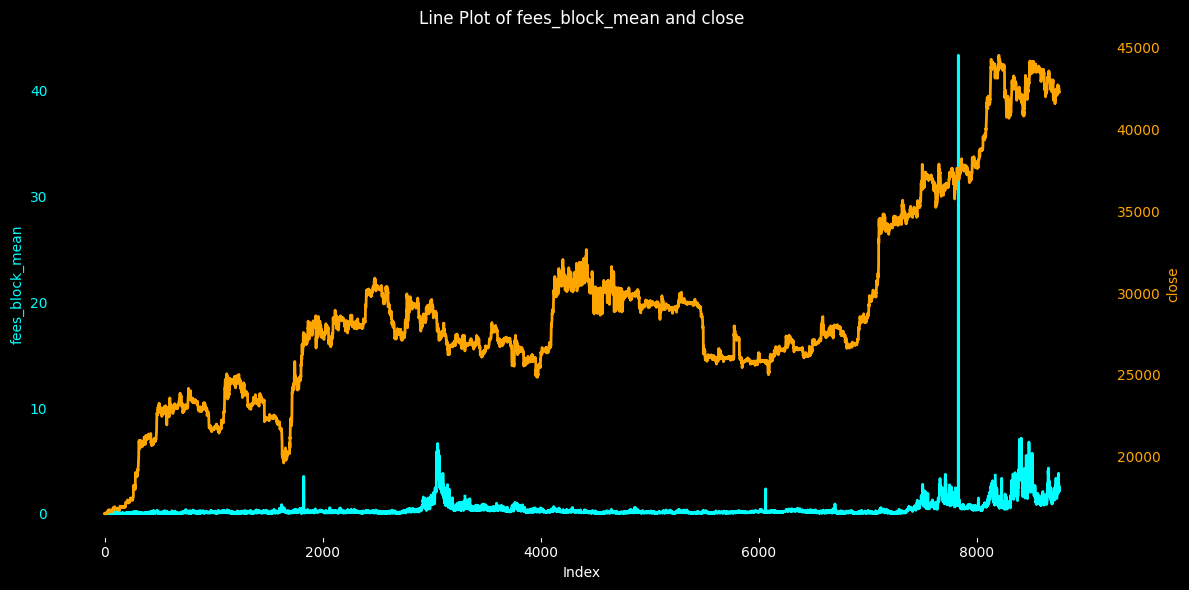

In [39]:
# fees_block_mean & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'fees_block_mean'을 주 Y축에 그리기
ax1.plot(eda_df['fees_block_mean'], label='fees_block_mean', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('fees_block_mean', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of fees_block_mean and close', color='white')
fig.tight_layout()
plt.show()


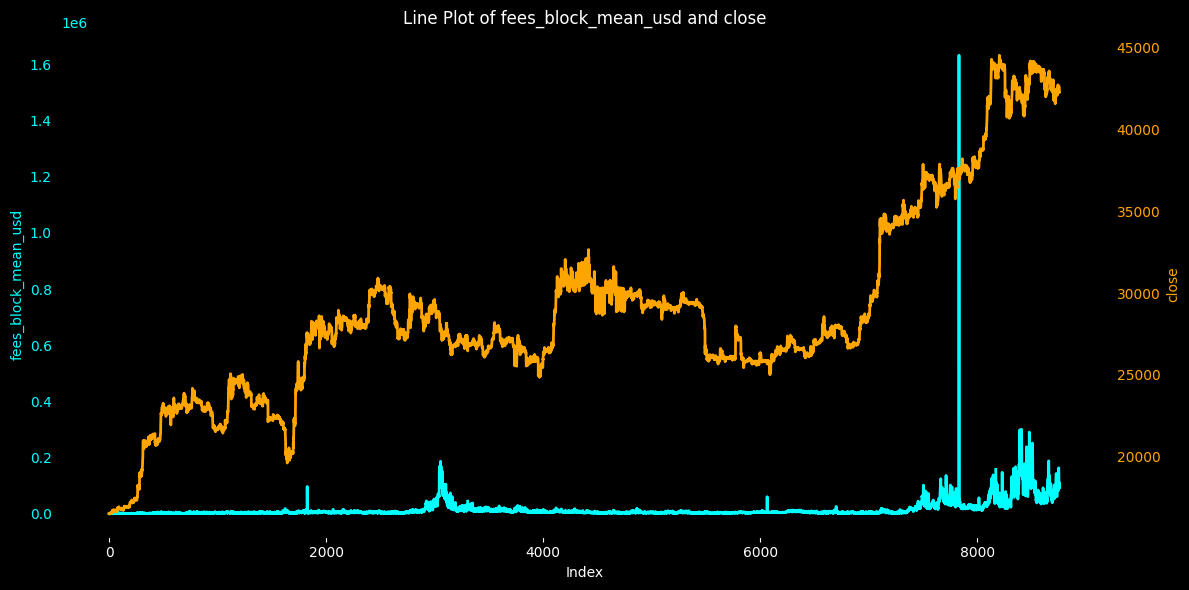

In [40]:
# fees_block_mean_usd & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'fees_block_mean_usd'을 주 Y축에 그리기
ax1.plot(eda_df['fees_block_mean_usd'], label='fees_block_mean_usd', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('fees_block_mean_usd', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of fees_block_mean_usd and close', color='white')
fig.tight_layout()
plt.show()


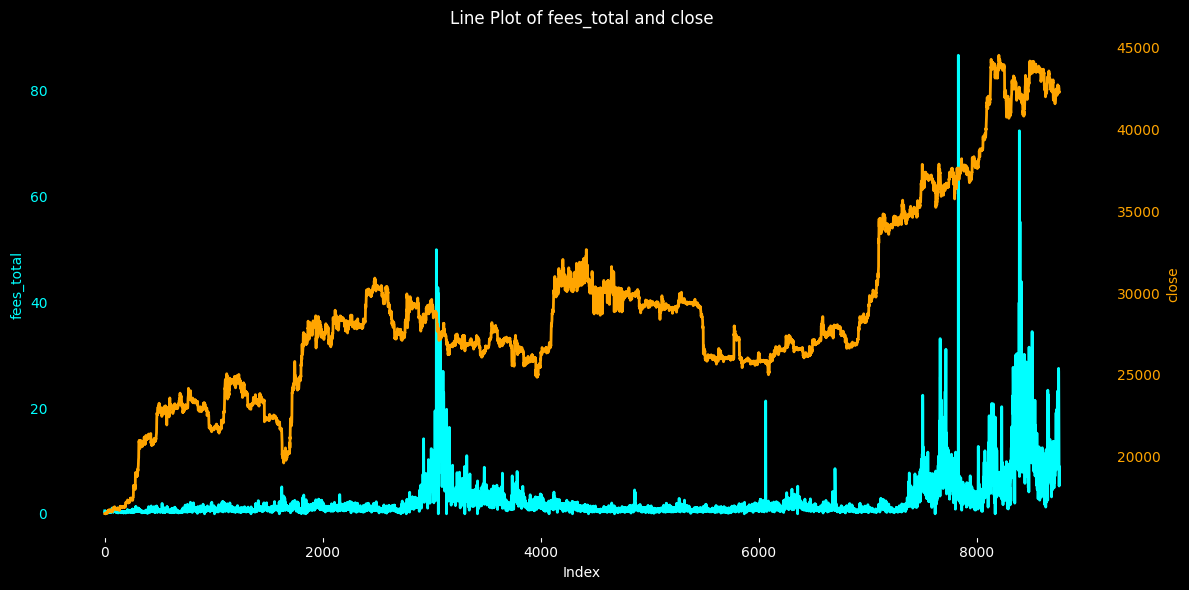

In [41]:
# fees_total & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'fees_total'을 주 Y축에 그리기
ax1.plot(eda_df['fees_total'], label='fees_total', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('fees_total', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of fees_total and close', color='white')
fig.tight_layout()
plt.show()


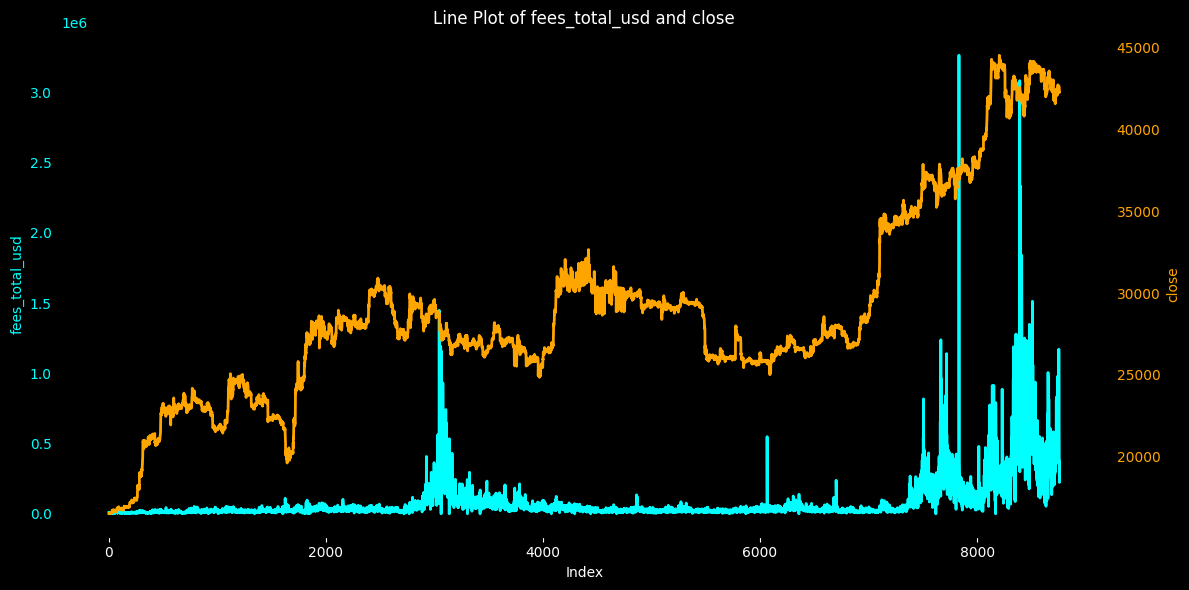

In [42]:
# fees_total_usd & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'fees_total_usd'을 주 Y축에 그리기
ax1.plot(eda_df['fees_total_usd'], label='fees_total_usd', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('fees_total_usd', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of fees_total_usd and close', color='white')
fig.tight_layout()
plt.show()


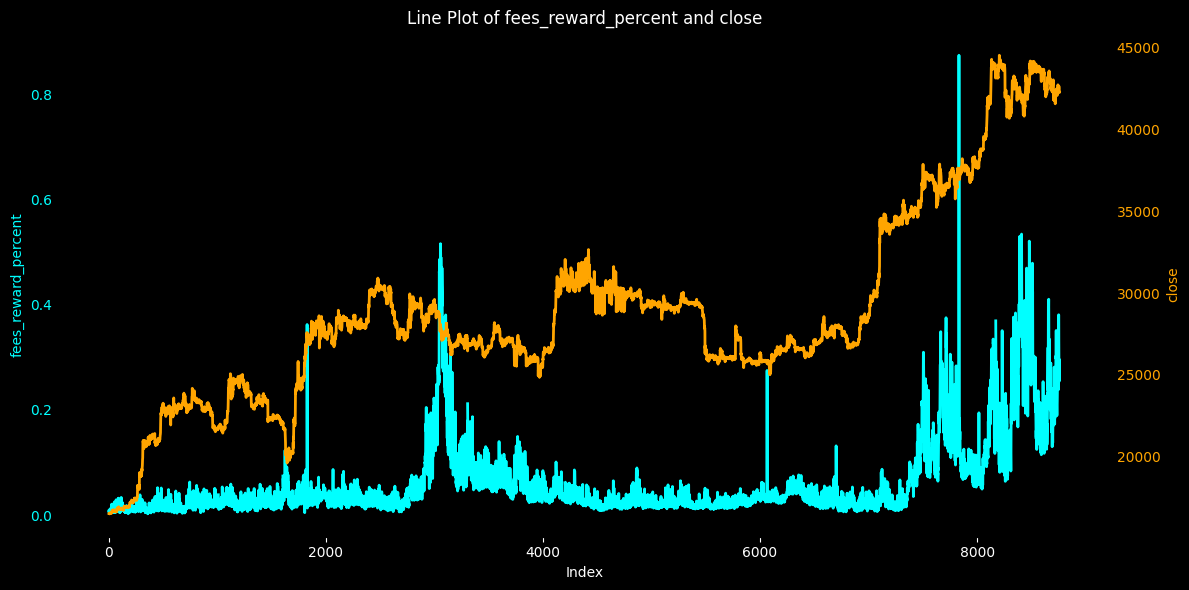

In [43]:
# fees_reward_percent & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'fees_reward_percent'을 주 Y축에 그리기
ax1.plot(eda_df['fees_reward_percent'], label='fees_reward_percent', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('fees_reward_percent', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of fees_reward_percent and close', color='white')
fig.tight_layout()
plt.show()


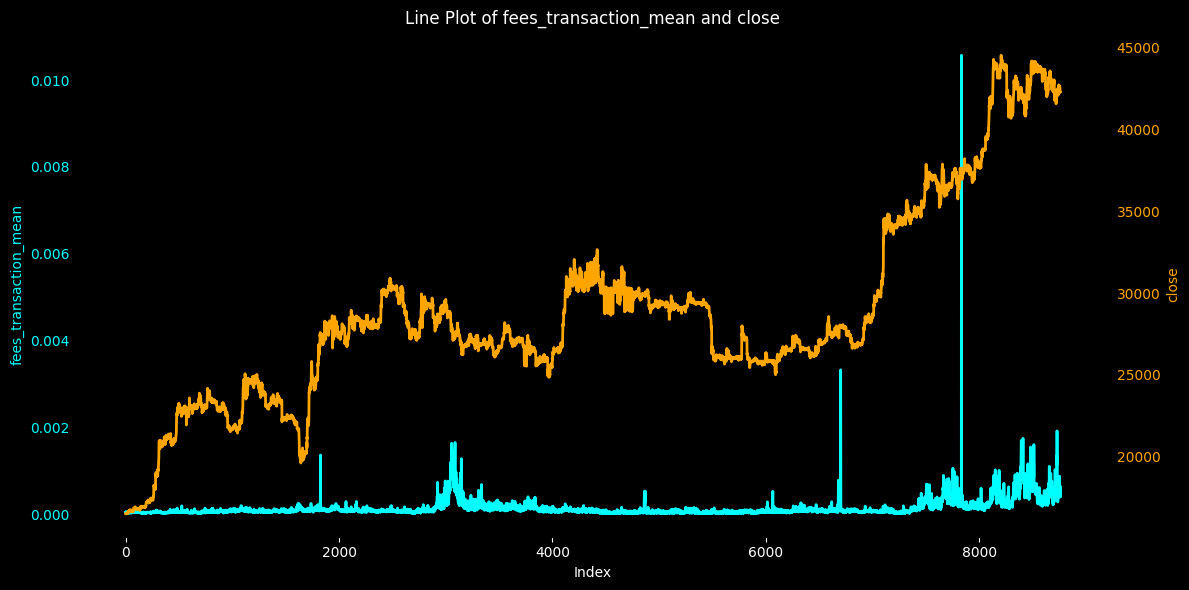

In [44]:
# fees_transaction_mean & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'fees_transaction_mean'을 주 Y축에 그리기
ax1.plot(eda_df['fees_transaction_mean'], label='fees_transaction_mean', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('fees_transaction_mean', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of fees_transaction_mean and close', color='white')
fig.tight_layout()
plt.show()


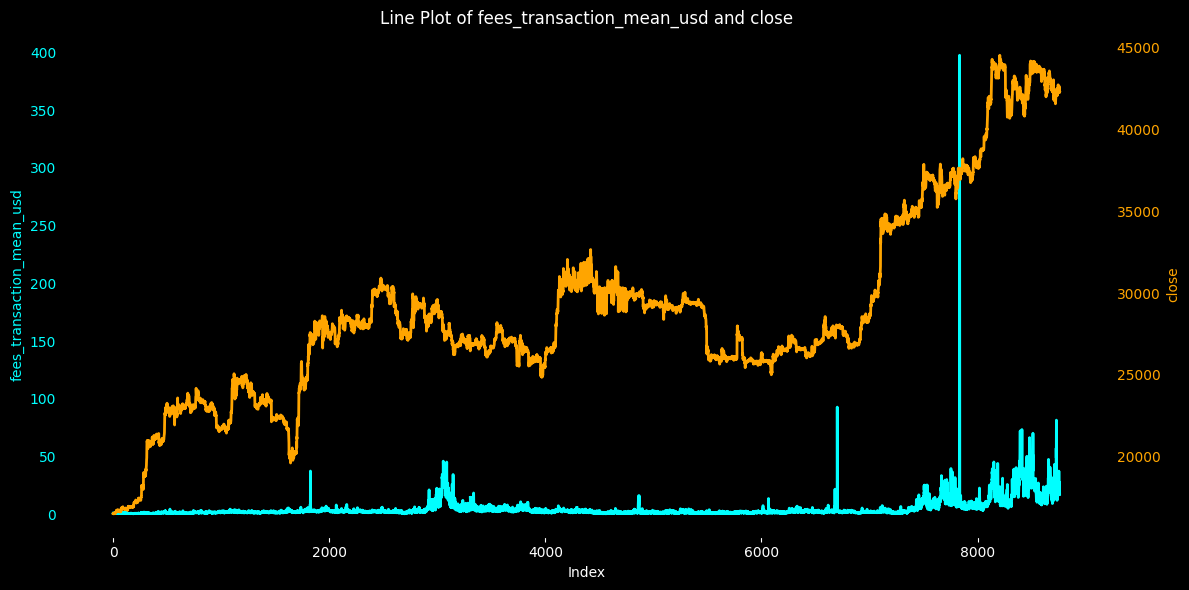

In [45]:
# fees_transaction_mean_usd & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'fees_transaction_mean_usd'을 주 Y축에 그리기
ax1.plot(eda_df['fees_transaction_mean_usd'], label='fees_transaction_mean_usd', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('fees_transaction_mean_usd', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of fees_transaction_mean_usd and close', color='white')
fig.tight_layout()
plt.show()


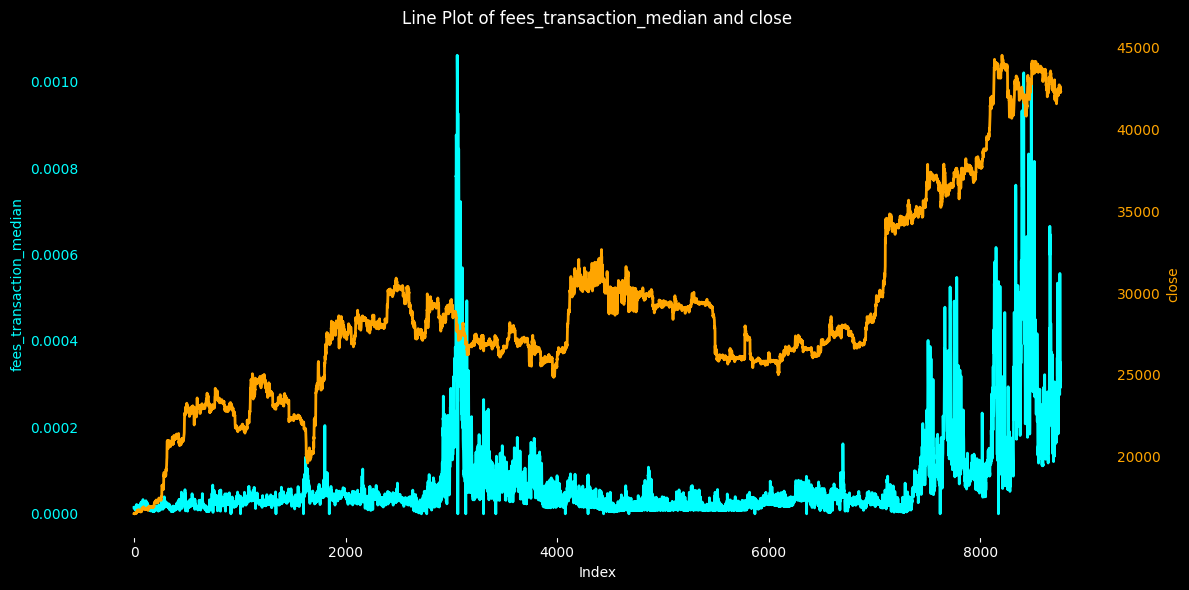

In [46]:
# fees_transaction_median & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'fees_transaction_median'을 주 Y축에 그리기
ax1.plot(eda_df['fees_transaction_median'], label='fees_transaction_median', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('fees_transaction_median', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of fees_transaction_median and close', color='white')
fig.tight_layout()
plt.show()


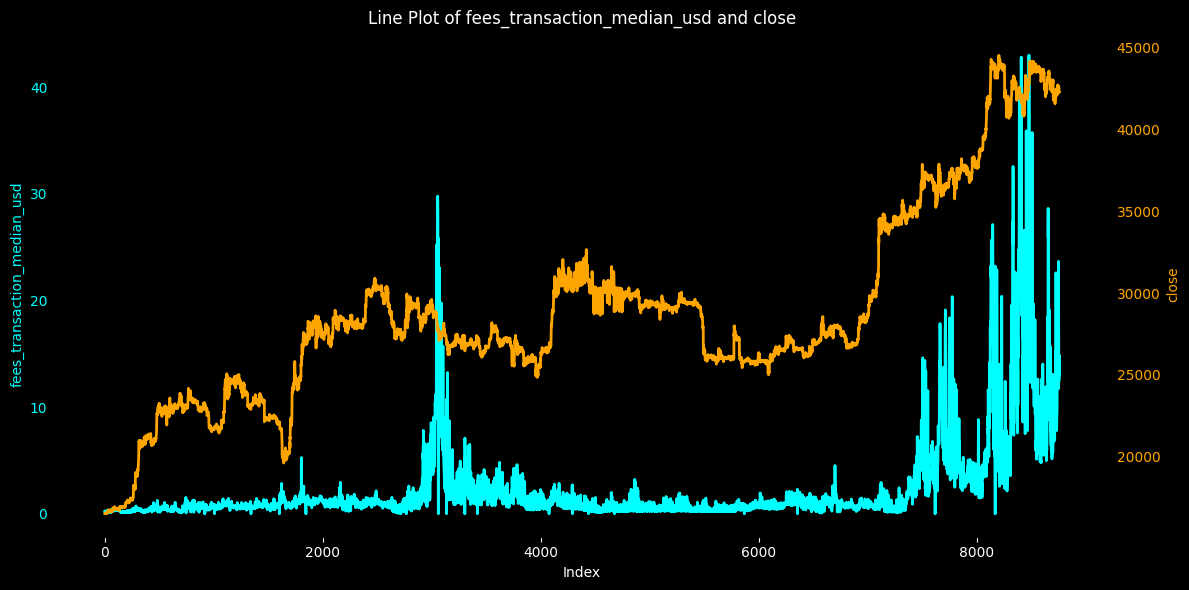

In [47]:
# fees_transaction_median_usd & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'fees_transaction_median_usd'을 주 Y축에 그리기
ax1.plot(eda_df['fees_transaction_median_usd'], label='fees_transaction_median_usd', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('fees_transaction_median_usd', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of fees_transaction_median_usd and close', color='white')
fig.tight_layout()
plt.show()


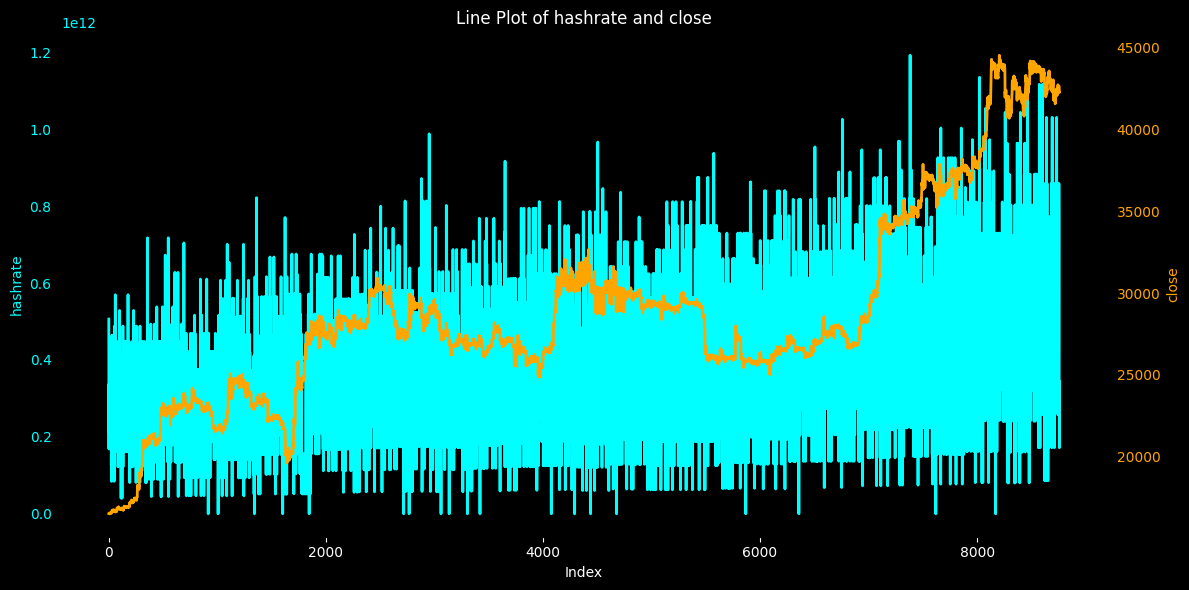

In [48]:
# hashrate & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'hashrate'을 주 Y축에 그리기
ax1.plot(eda_df['hashrate'], label='hashrate', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('hashrate', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of hashrate and close', color='white')
fig.tight_layout()
plt.show()


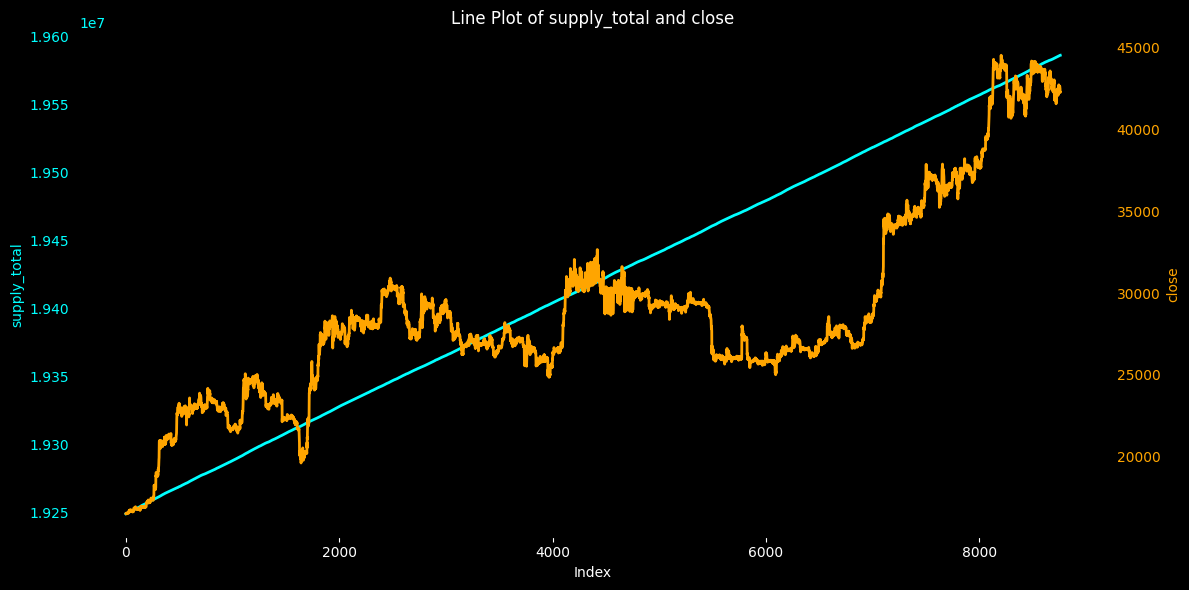

In [49]:
# supply_total & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'supply_total'을 주 Y축에 그리기
ax1.plot(eda_df['supply_total'], label='supply_total', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('supply_total', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of supply_total and close', color='white')
fig.tight_layout()
plt.show()


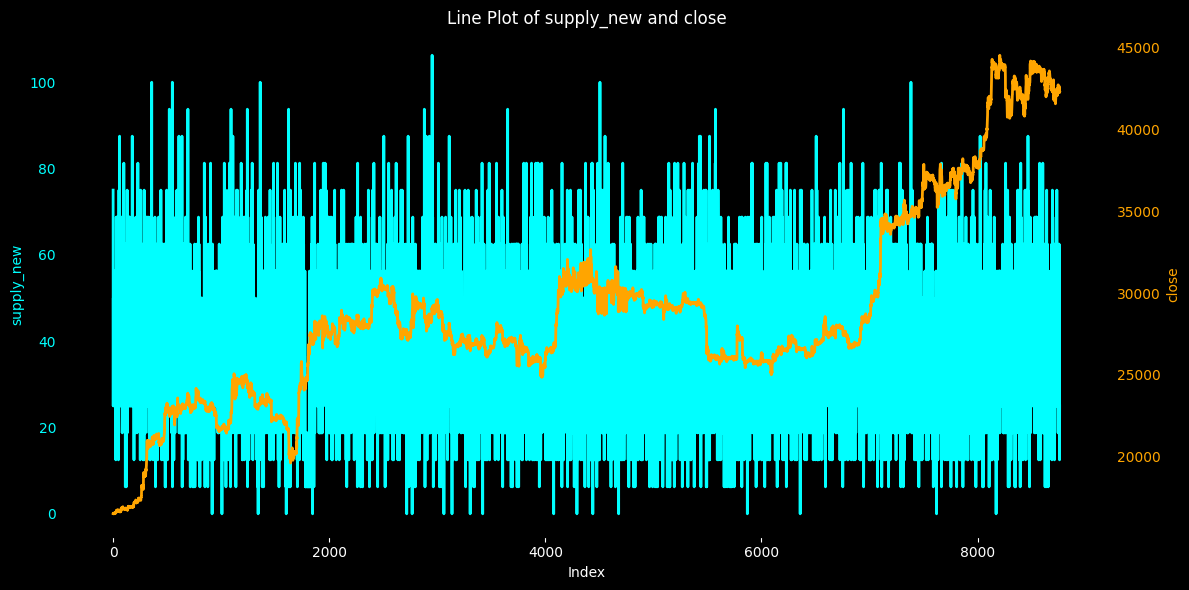

In [50]:
# supply_new & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'supply_new'을 주 Y축에 그리기
ax1.plot(eda_df['supply_new'], label='supply_new', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('supply_new', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of supply_new and close', color='white')
fig.tight_layout()
plt.show()


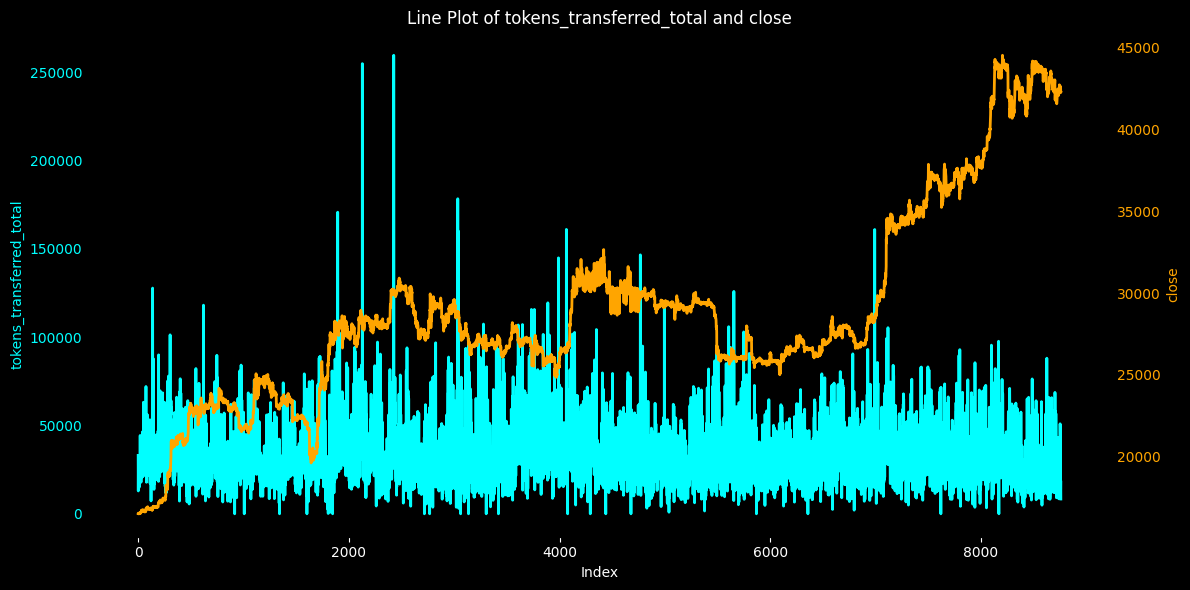

In [51]:
# tokens_transferred_total & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'tokens_transferred_total'을 주 Y축에 그리기
ax1.plot(eda_df['tokens_transferred_total'], label='tokens_transferred_total', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('tokens_transferred_total', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of tokens_transferred_total and close', color='white')
fig.tight_layout()
plt.show()


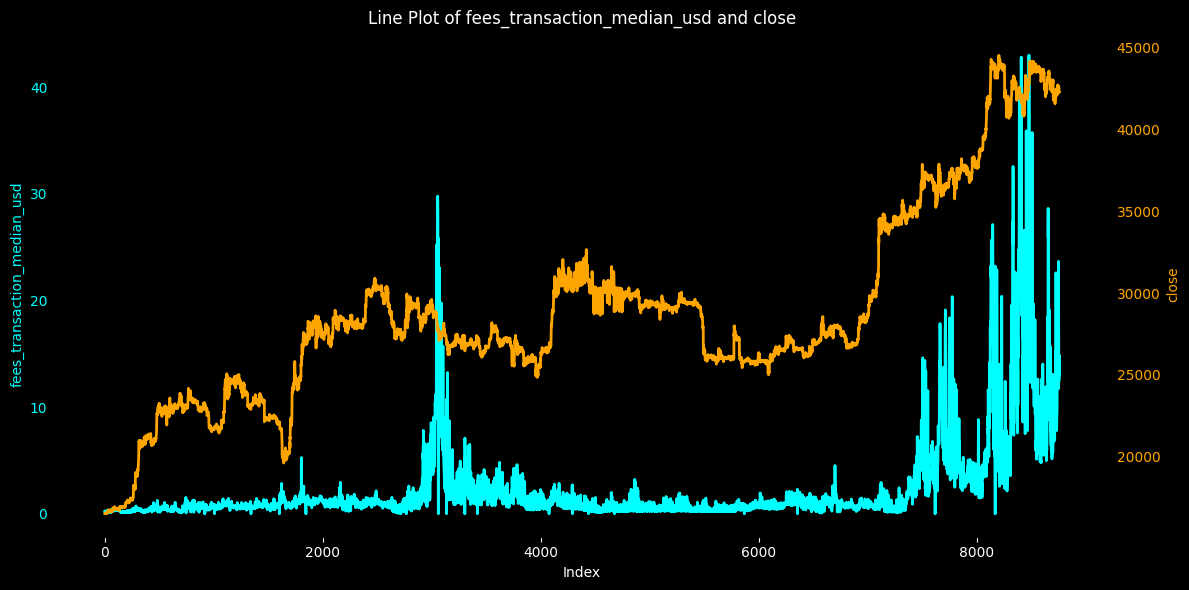

In [52]:
# fees_transaction_median_usd & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'fees_transaction_median_usd'을 주 Y축에 그리기
ax1.plot(eda_df['fees_transaction_median_usd'], label='fees_transaction_median_usd', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('fees_transaction_median_usd', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of fees_transaction_median_usd and close', color='white')
fig.tight_layout()
plt.show()


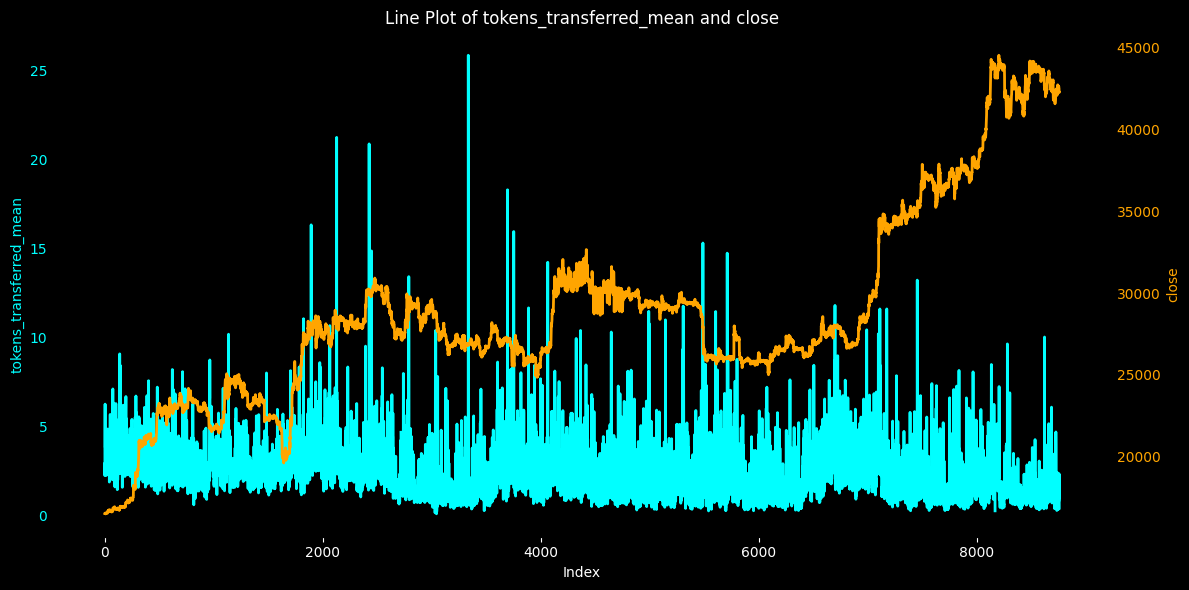

In [53]:
# tokens_transferred_mean & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'tokens_transferred_mean'을 주 Y축에 그리기
ax1.plot(eda_df['tokens_transferred_mean'], label='tokens_transferred_mean', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('tokens_transferred_mean', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of tokens_transferred_mean and close', color='white')
fig.tight_layout()
plt.show()


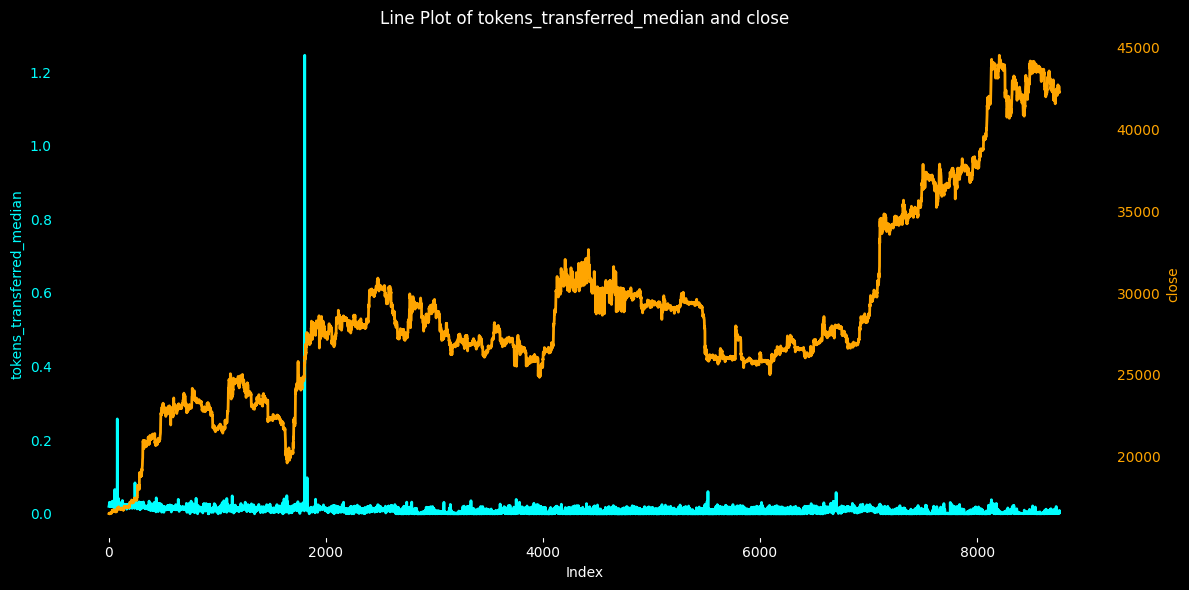

In [54]:
# tokens_transferred_median & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'tokens_transferred_median'을 주 Y축에 그리기
ax1.plot(eda_df['tokens_transferred_median'], label='tokens_transferred_median', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('tokens_transferred_median', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of tokens_transferred_median and close', color='white')
fig.tight_layout()
plt.show()


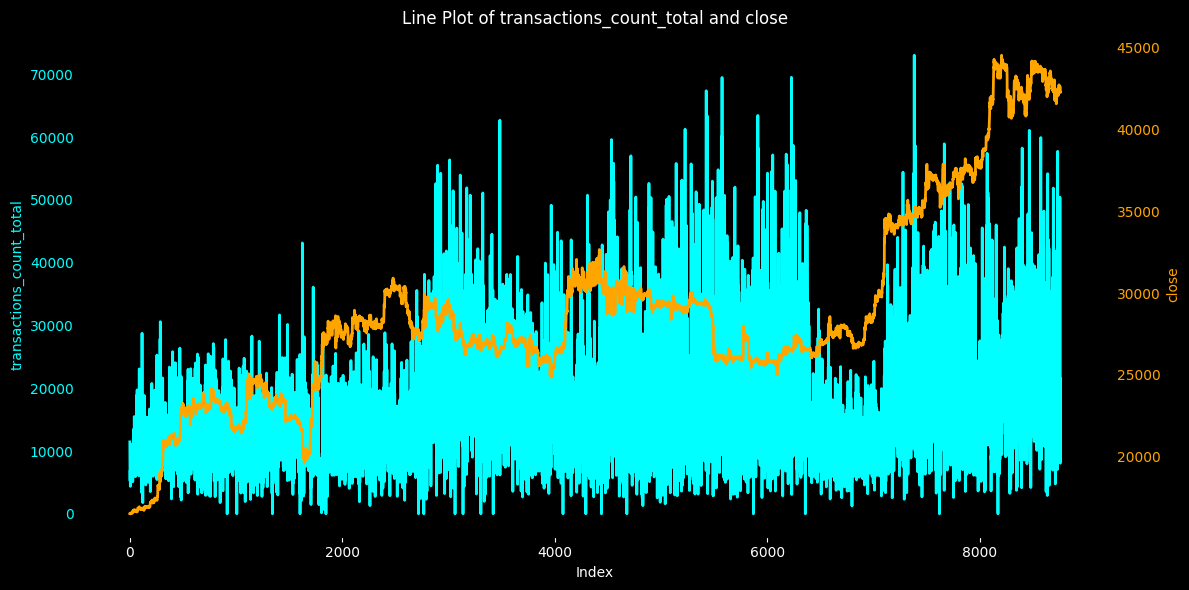

In [55]:
# transactions_count_total & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'transactions_count_total'을 주 Y축에 그리기
ax1.plot(eda_df['transactions_count_total'], label='transactions_count_total', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('transactions_count_total', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of transactions_count_total and close', color='white')
fig.tight_layout()
plt.show()


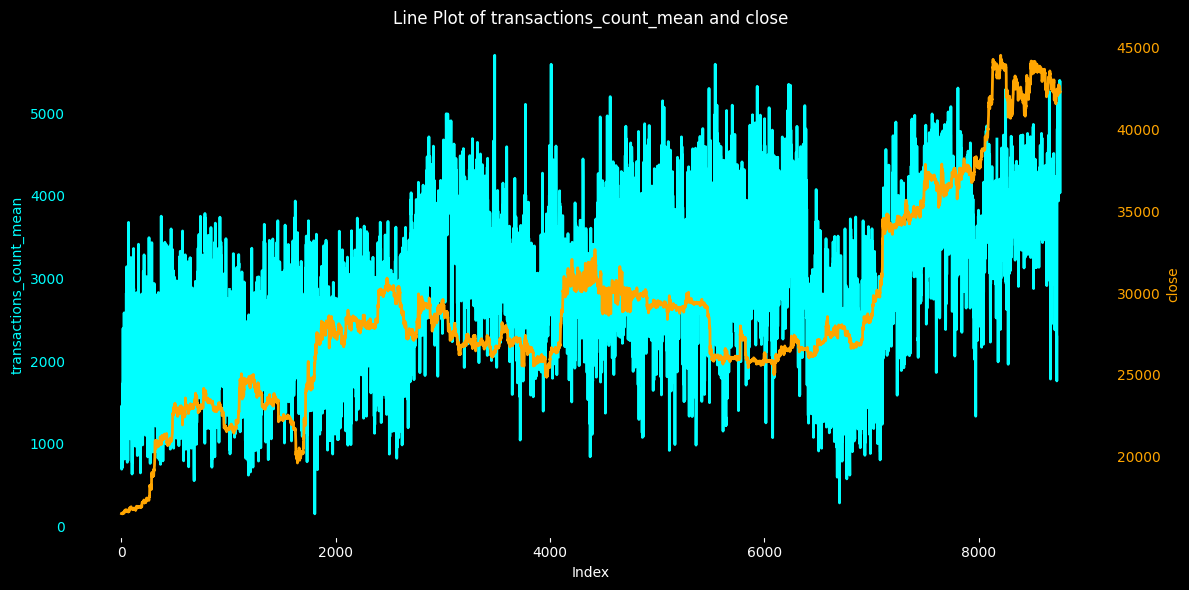

In [56]:
# transactions_count_mean & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'transactions_count_mean'을 주 Y축에 그리기
ax1.plot(eda_df['transactions_count_mean'], label='transactions_count_mean', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('transactions_count_mean', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of transactions_count_mean and close', color='white')
fig.tight_layout()
plt.show()


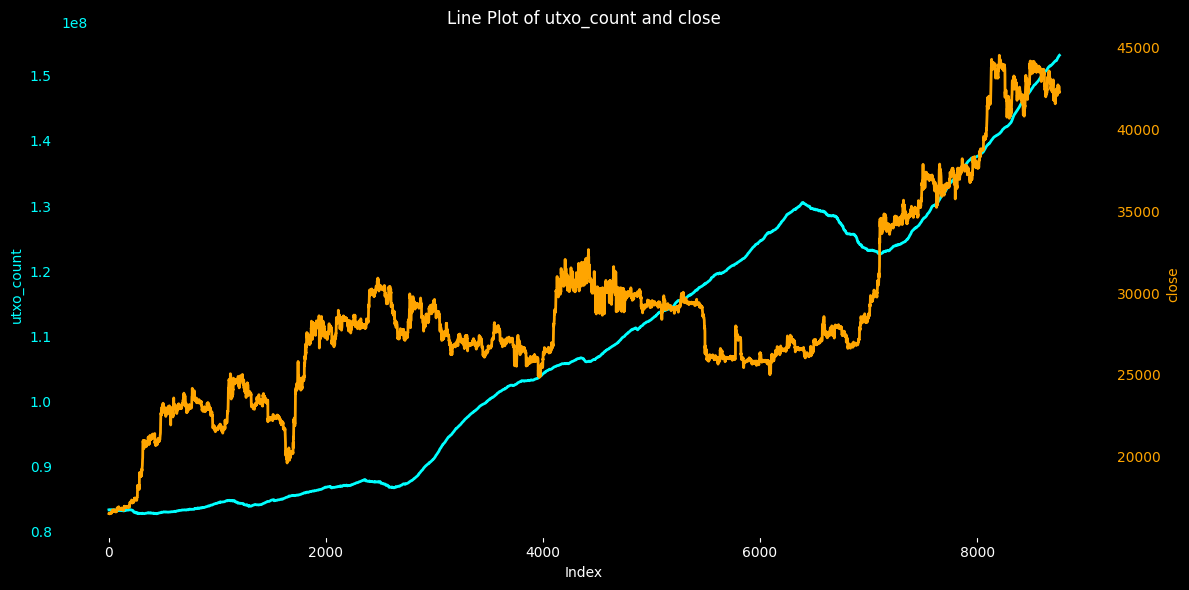

In [57]:
# utxo_count & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'utxo_count'을 주 Y축에 그리기
ax1.plot(eda_df['utxo_count'], label='utxo_count', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('utxo_count', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of utxo_count and close', color='white')
fig.tight_layout()
plt.show()


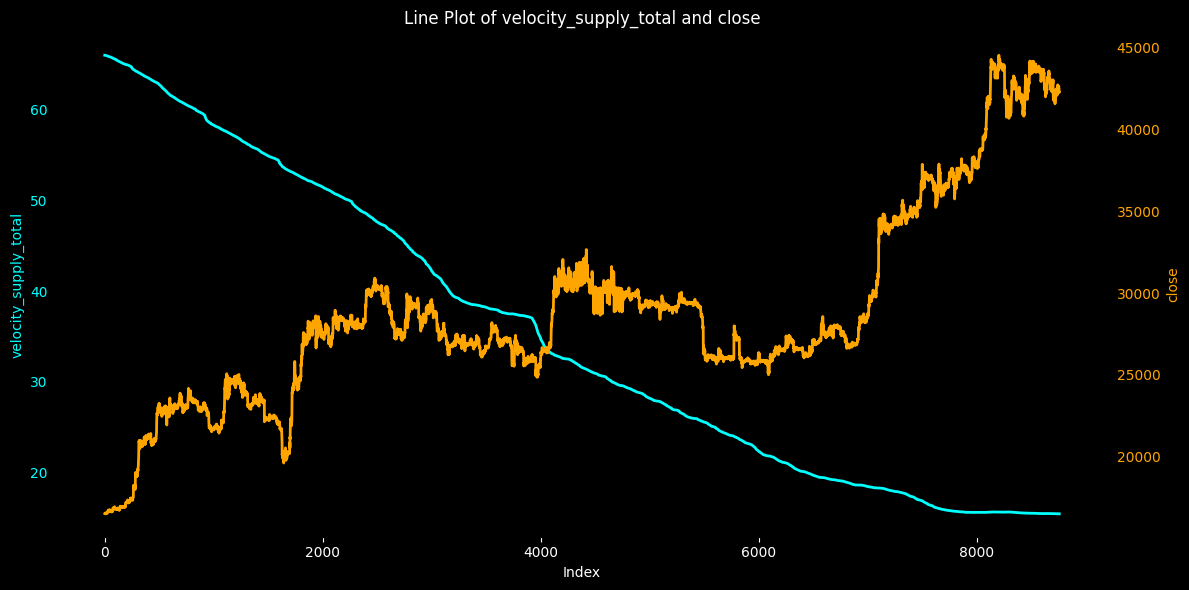

In [58]:
# velocity_supply_total & close
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')

# 'velocity_supply_total'을 주 Y축에 그리기
ax1.plot(eda_df['velocity_supply_total'], label='velocity_supply_total', color='cyan', linewidth=2)
ax1.set_xlabel('Index', color='white')
ax1.set_ylabel('velocity_supply_total', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')
ax1.tick_params(axis='x', colors='white')
ax1.set_facecolor('black')

# 보조 Y축 생성
ax2 = ax1.twinx()
ax2.plot(eda_df['close'], label='close', color='orange', linewidth=2)
ax2.set_ylabel('close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 제목 및 범례 추가
plt.title('Line Plot of velocity_supply_total and close', color='white')
fig.tight_layout()
plt.show()


## Scatter Plot with Regression Line

In [59]:
# Close와의 상관계수 계산
close_corr_df = eda_df.drop(columns='ID', inplace=False).corr()['close']

# 상관계수가 0.5 이상이거나 -0.5 이하인 변수 선택
strong_correlations = close_corr_df[(close_corr_df >= 0.5) | (close_corr_df <= -0.5)]
print(strong_correlations)

open_interest                  0.889183
close                          1.000000
blockreward_usd                0.537638
difficulty                     0.882241
fees_block_mean_usd            0.551055
fees_total                     0.527152
fees_total_usd                 0.596680
fees_reward_percent            0.623586
fees_transaction_mean_usd      0.554984
fees_transaction_median        0.545186
fees_transaction_median_usd    0.621048
supply_total                   0.806199
utxo_count                     0.763803
velocity_supply_total         -0.739433
Name: close, dtype: float64


Correlation between open_interest and Close: 0.8891826151056773


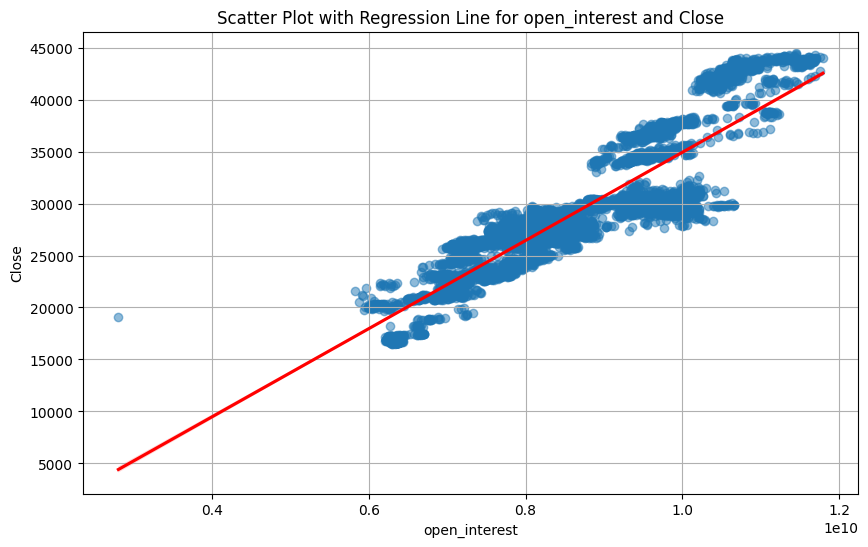

In [60]:
# open_interest와 Close의 상관계수 계산
correlation = eda_df['open_interest'].corr(eda_df['close'])
print(f"Correlation between open_interest and Close: {correlation}")

# 산점도와 회귀선 그리기
plt.figure(figsize=(10, 6))
sns.regplot(x='open_interest', y='close', data=eda_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Scatter Plot with Regression Line for open_interest and Close')
plt.xlabel('open_interest')
plt.ylabel('Close')
plt.grid(True)
plt.show()

Correlation between blockreward_usd and Close: 0.5376383999682416


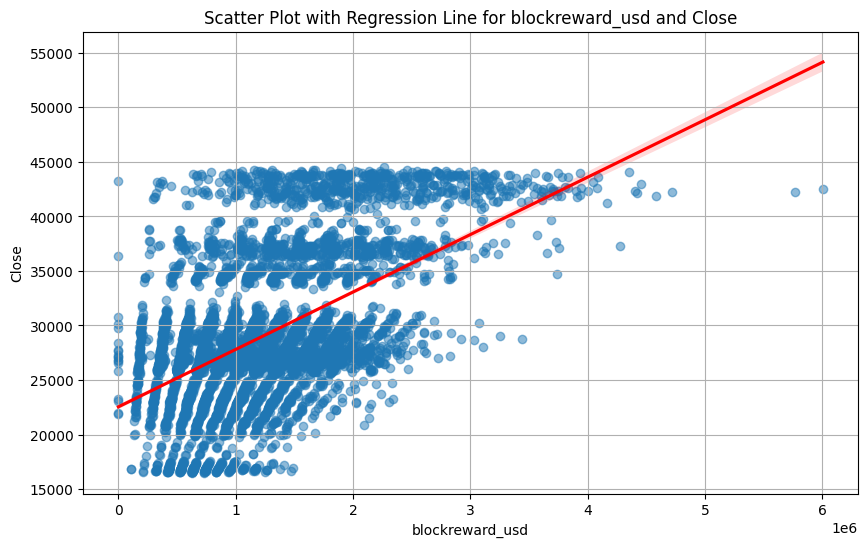

In [61]:
# blockreward_usd와 Close의 상관계수 계산
correlation = eda_df['blockreward_usd'].corr(eda_df['close'])
print(f"Correlation between blockreward_usd and Close: {correlation}")

# 산점도와 회귀선 그리기
plt.figure(figsize=(10, 6))
sns.regplot(x='blockreward_usd', y='close', data=eda_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Scatter Plot with Regression Line for blockreward_usd and Close')
plt.xlabel('blockreward_usd')
plt.ylabel('Close')
plt.grid(True)
plt.show()

Correlation between difficulty and Close: 0.8822405896899602


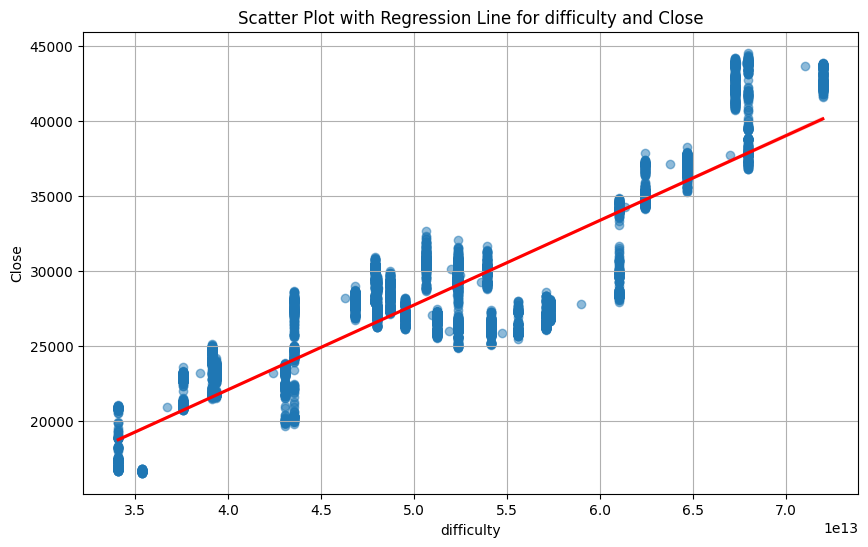

In [62]:
#difficulty와 Close의 상관계수 계산
correlation = eda_df['difficulty'].corr(eda_df['close'])
print(f"Correlation between difficulty and Close: {correlation}")

# 산점도와 회귀선 그리기
plt.figure(figsize=(10, 6))
sns.regplot(x='difficulty', y='close', data=eda_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Scatter Plot with Regression Line for difficulty and Close')
plt.xlabel('difficulty')
plt.ylabel('Close')
plt.grid(True)
plt.show()

Correlation between fees_block_mean_usd and Close: 0.5510548772271449


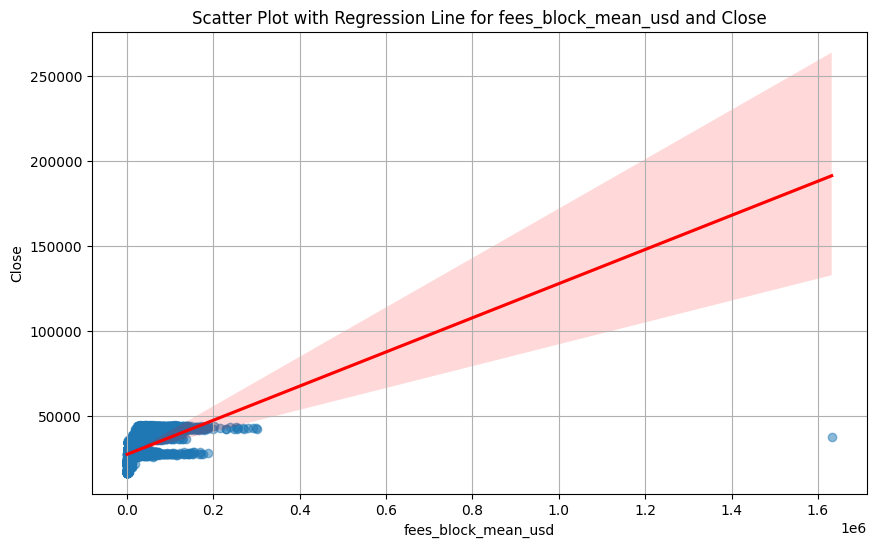

In [63]:
#fees_block_mean_usd 와 Close의 상관계수 계산
correlation = eda_df['fees_block_mean_usd'].corr(eda_df['close'])
print(f"Correlation between fees_block_mean_usd and Close: {correlation}")

# 산점도와 회귀선 그리기
plt.figure(figsize=(10, 6))
sns.regplot(x='fees_block_mean_usd', y='close', data=eda_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Scatter Plot with Regression Line for fees_block_mean_usd and Close')
plt.xlabel('fees_block_mean_usd')
plt.ylabel('Close')
plt.grid(True)
plt.show()

Correlation between fees_total and Close: 0.527152477758778


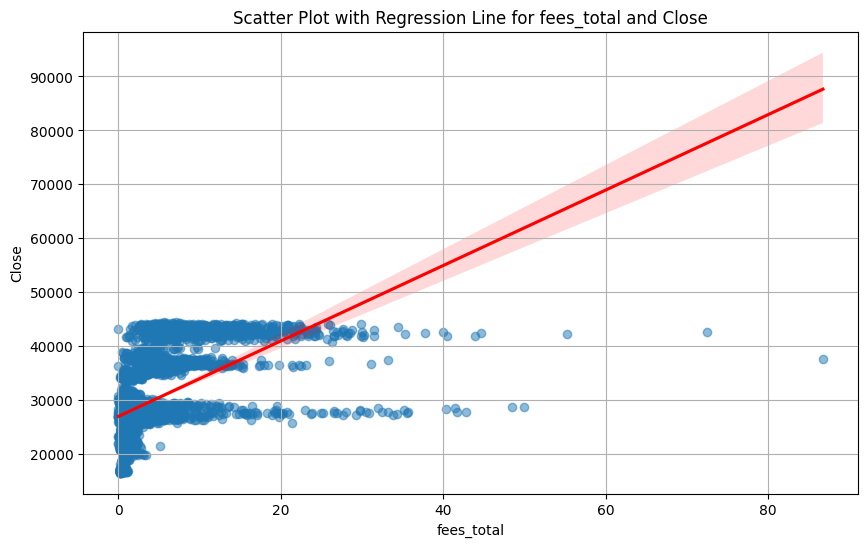

In [64]:
#fees_total 와 Close의 상관계수 계산
correlation = eda_df['fees_total'].corr(eda_df['close'])
print(f"Correlation between fees_total and Close: {correlation}")

# 산점도와 회귀선 그리기
plt.figure(figsize=(10, 6))
sns.regplot(x='fees_total', y='close', data=eda_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Scatter Plot with Regression Line for fees_total and Close')
plt.xlabel('fees_total')
plt.ylabel('Close')
plt.grid(True)
plt.show()

Correlation between fees_total_usd and Close: 0.5966802558003146


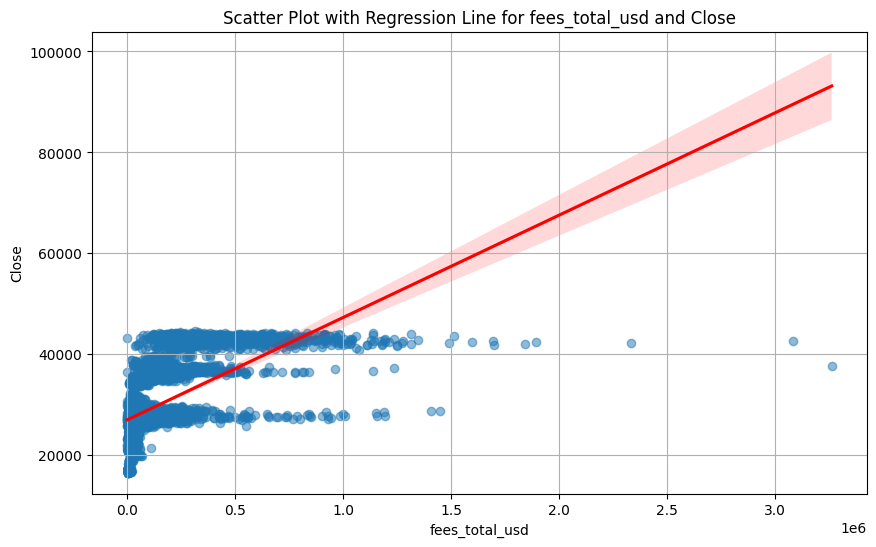

In [65]:
#fees_total_usd 와 Close의 상관계수 계산
correlation = eda_df['fees_total_usd'].corr(eda_df['close'])
print(f"Correlation between fees_total_usd and Close: {correlation}")

# 산점도와 회귀선 그리기
plt.figure(figsize=(10, 6))
sns.regplot(x='fees_total_usd', y='close', data=eda_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Scatter Plot with Regression Line for fees_total_usd and Close')
plt.xlabel('fees_total_usd')
plt.ylabel('Close')
plt.grid(True)
plt.show()

Correlation between fees_reward_percent and Close: 0.6235863263414926


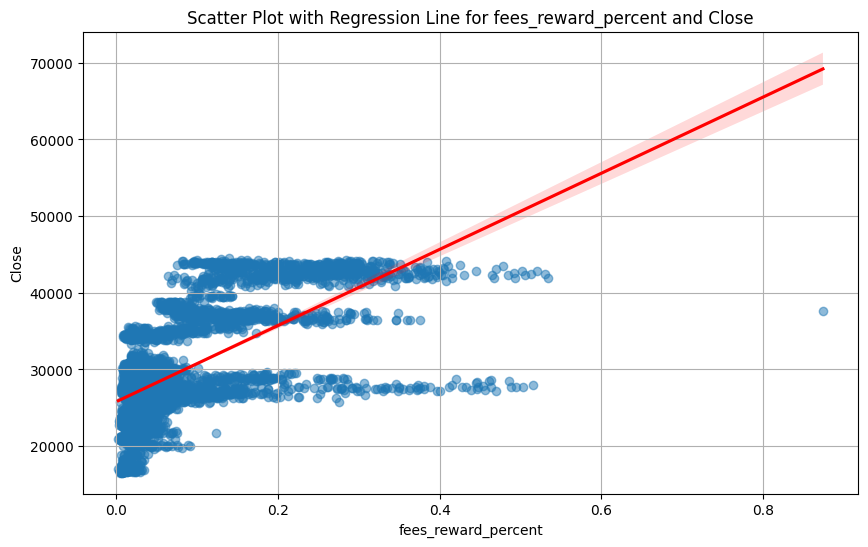

In [66]:
#fees_reward_percent 와 Close의 상관계수 계산
correlation = eda_df['fees_reward_percent'].corr(eda_df['close'])
print(f"Correlation between fees_reward_percent and Close: {correlation}")

# 산점도와 회귀선 그리기
plt.figure(figsize=(10, 6))
sns.regplot(x='fees_reward_percent', y='close', data=eda_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Scatter Plot with Regression Line for fees_reward_percent and Close')
plt.xlabel('fees_reward_percent')
plt.ylabel('Close')
plt.grid(True)
plt.show()

Correlation between fees_transaction_mean_usd and Close: 0.5549844475369138


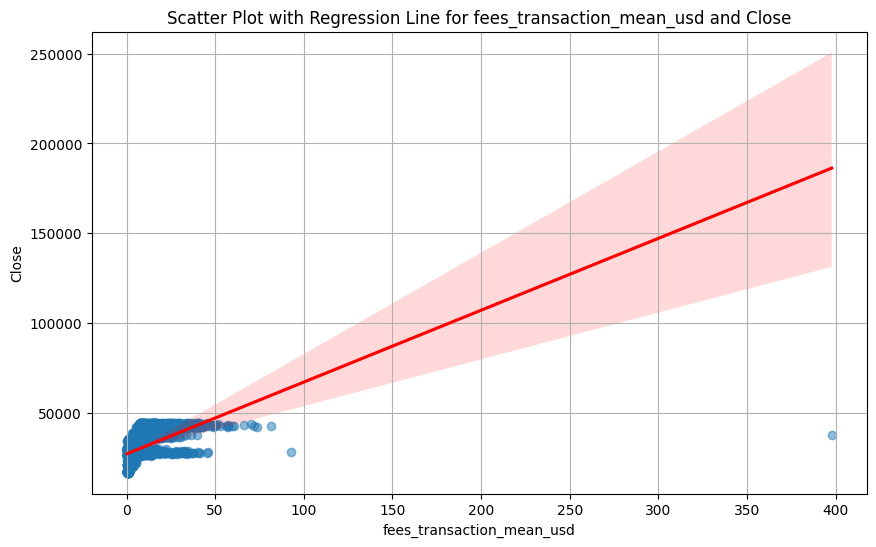

In [67]:
#fees_transaction_mean_usd 와 Close의 상관계수 계산
correlation = eda_df['fees_transaction_mean_usd'].corr(eda_df['close'])
print(f"Correlation between fees_transaction_mean_usd and Close: {correlation}")

# 산점도와 회귀선 그리기
plt.figure(figsize=(10, 6))
sns.regplot(x='fees_transaction_mean_usd', y='close', data=eda_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Scatter Plot with Regression Line for fees_transaction_mean_usd and Close')
plt.xlabel('fees_transaction_mean_usd')
plt.ylabel('Close')
plt.grid(True)
plt.show()

Correlation between fees_transaction_median and Close: 0.54518636814997


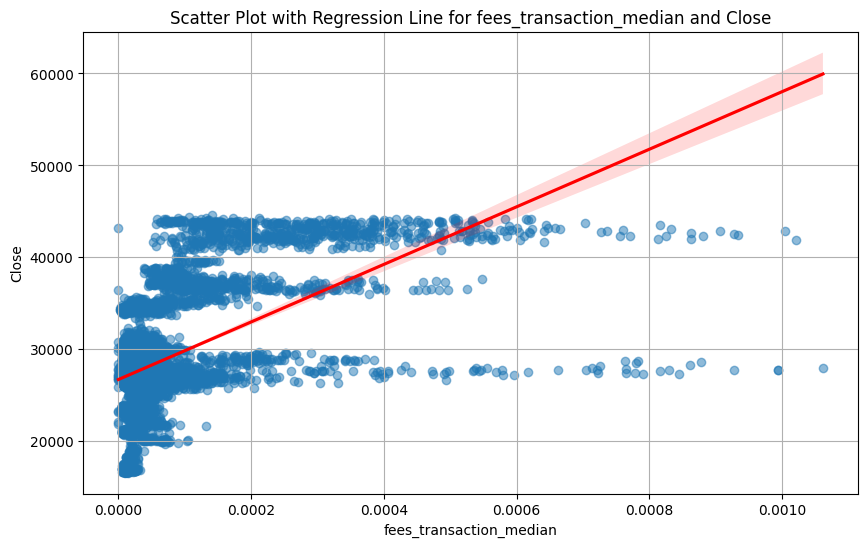

In [68]:
#fees_transaction_median 와 Close의 상관계수 계산
correlation = eda_df['fees_transaction_median'].corr(eda_df['close'])
print(f"Correlation between fees_transaction_median and Close: {correlation}")

# 산점도와 회귀선 그리기
plt.figure(figsize=(10, 6))
sns.regplot(x='fees_transaction_median', y='close', data=eda_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Scatter Plot with Regression Line for fees_transaction_median and Close')
plt.xlabel('fees_transaction_median')
plt.ylabel('Close')
plt.grid(True)
plt.show()

Correlation between fees_transaction_median_usd and Close: 0.621048237987581


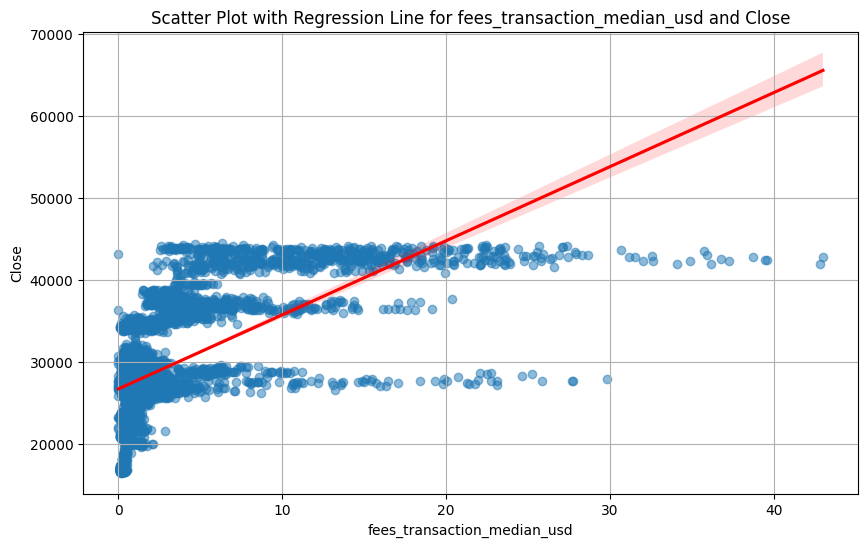

In [69]:
#fees_transaction_median_usd 와 Close의 상관계수 계산
correlation = eda_df['fees_transaction_median_usd'].corr(eda_df['close'])
print(f"Correlation between fees_transaction_median_usd and Close: {correlation}")

# 산점도와 회귀선 그리기
plt.figure(figsize=(10, 6))
sns.regplot(x='fees_transaction_median_usd', y='close', data=eda_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Scatter Plot with Regression Line for fees_transaction_median_usd and Close')
plt.xlabel('fees_transaction_median_usd')
plt.ylabel('Close')
plt.grid(True)
plt.show()

Correlation between supply_total and Close: 0.8061994470767999


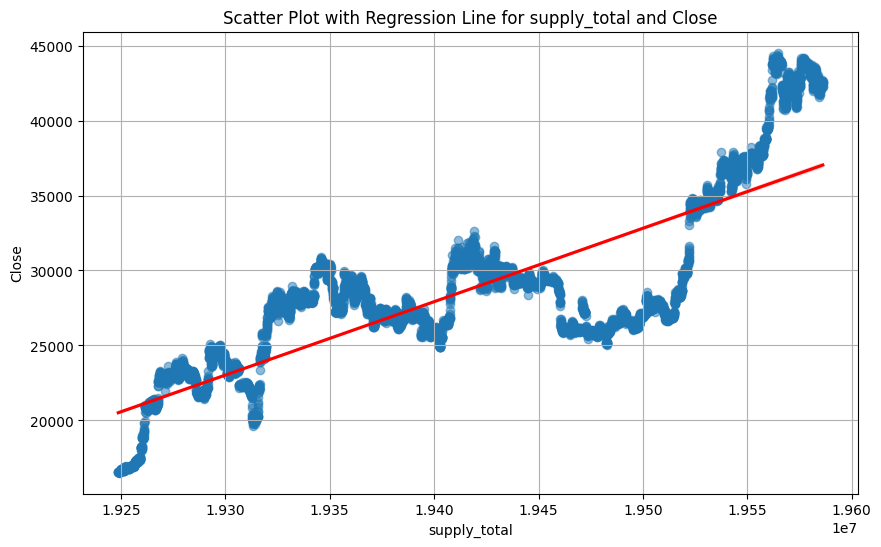

In [70]:
#supply_total 와 Close의 상관계수 계산
correlation = eda_df['supply_total'].corr(eda_df['close'])
print(f"Correlation between supply_total and Close: {correlation}")

# 산점도와 회귀선 그리기
plt.figure(figsize=(10, 6))
sns.regplot(x='supply_total', y='close', data=eda_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Scatter Plot with Regression Line for supply_total and Close')
plt.xlabel('supply_total')
plt.ylabel('Close')
plt.grid(True)
plt.show()

Correlation between utxo_count and Close: 0.7638025920927073


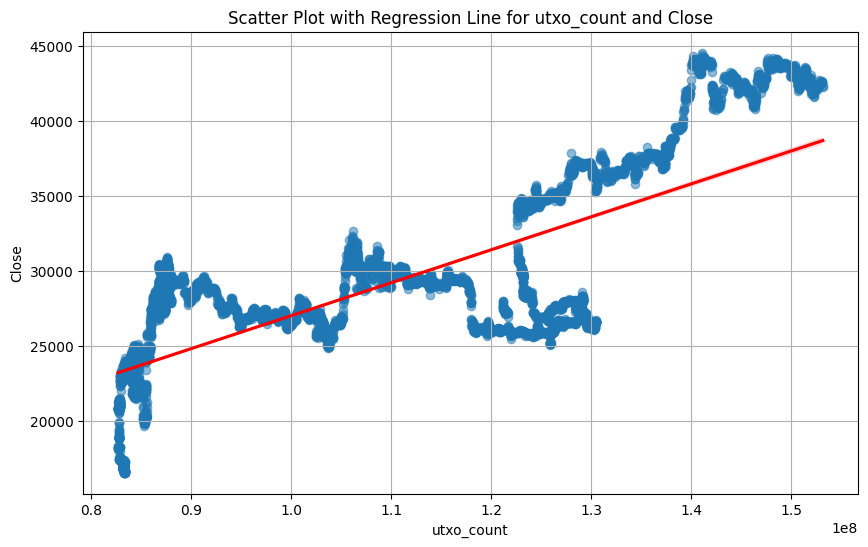

In [71]:
#utxo_count 와 Close의 상관계수 계산
correlation = eda_df['utxo_count'].corr(eda_df['close'])
print(f"Correlation between utxo_count and Close: {correlation}")

# 산점도와 회귀선 그리기
plt.figure(figsize=(10, 6))
sns.regplot(x='utxo_count', y='close', data=eda_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Scatter Plot with Regression Line for utxo_count and Close')
plt.xlabel('utxo_count')
plt.ylabel('Close')
plt.grid(True)
plt.show()

Correlation between velocity_supply_total and Close: -0.7394334959626412


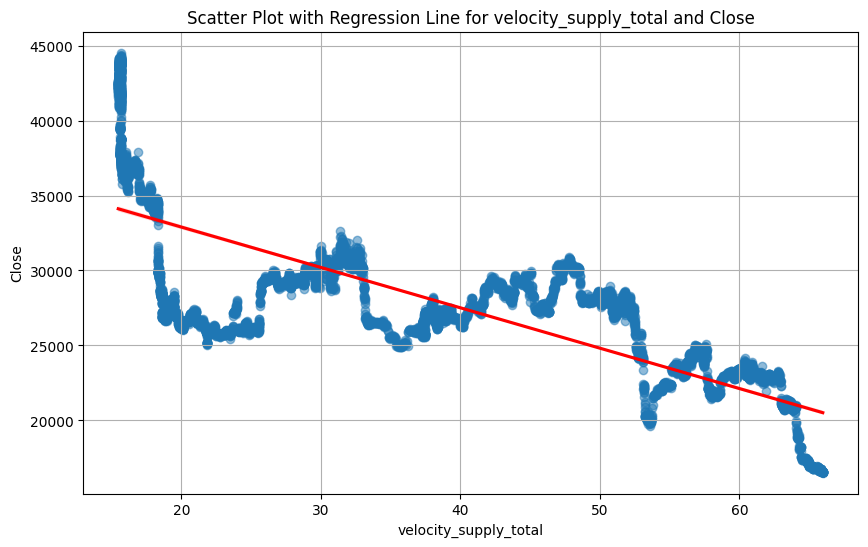

In [72]:
#velocity_supply_total 와 Close의 상관계수 계산
correlation = eda_df['velocity_supply_total'].corr(eda_df['close'])
print(f"Correlation between velocity_supply_total and Close: {correlation}")

# 산점도와 회귀선 그리기
plt.figure(figsize=(10, 6))
sns.regplot(x='velocity_supply_total', y='close', data=eda_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Scatter Plot with Regression Line for velocity_supply_total and Close')
plt.xlabel('velocity_supply_total')
plt.ylabel('Close')
plt.grid(True)
plt.show()

## 계절성 확인

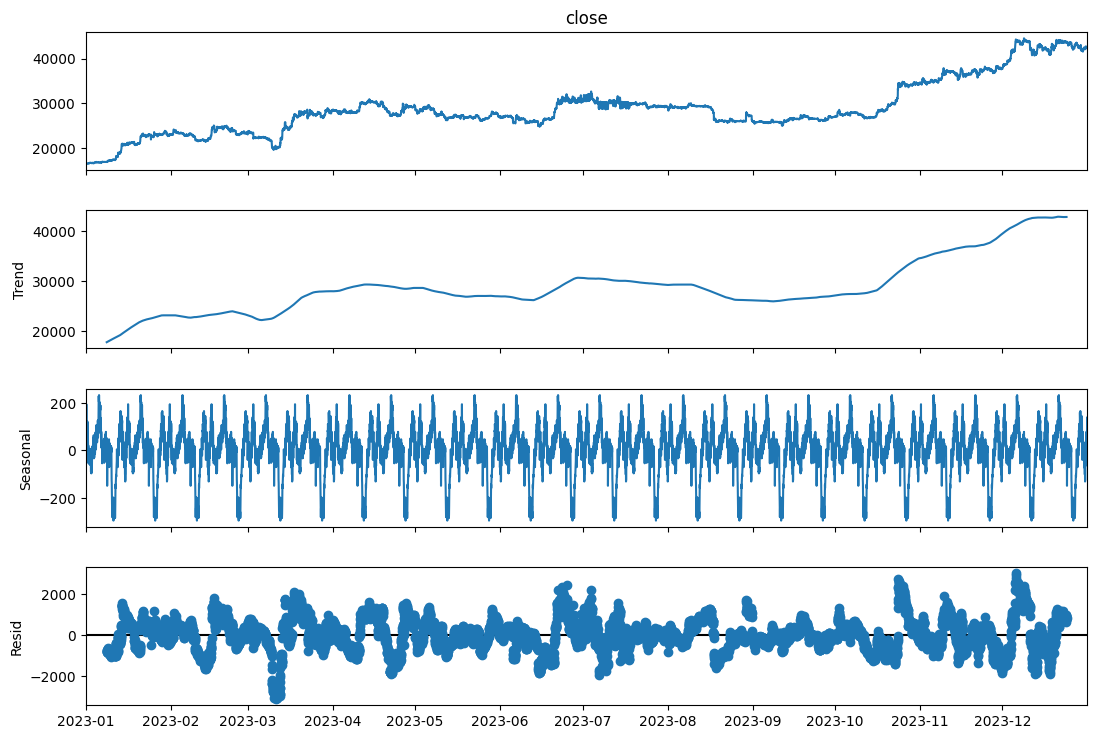

In [73]:
from statsmodels.tsa.seasonal import seasonal_decompose
# ID 열이 datetime 형식인지 확인
eda_df['Date'] = pd.to_datetime(eda_df['ID'])
# Date를 인덱스로 설정
eda_df.set_index('Date', inplace=True)

# seasonal decomposition 수행
result = seasonal_decompose(eda_df['close'], model='additive', period=365)

# Plot decomposition
result.plot()
plt.gcf().set_size_inches(12, 8)
#plt.show()

**Seasonal**
데이터는 매일 반복되는 주기를 가지고 있음을 확인

**residual**
데이터의 패턴에서 계절성 및 추세를 제거하고 난 후에도 여전히 불규칙한 요인들이 존재함
잔차의 분포를 보았을 때, 잔차의 값이 크게 변동하며 0을 기준으로 양수와 음수로 분포.
즉, 모델이 추세와 계절설을 잘 분리했으나, 데이터에 남아 있는 예측 불가능한 부분이 여전히 존재


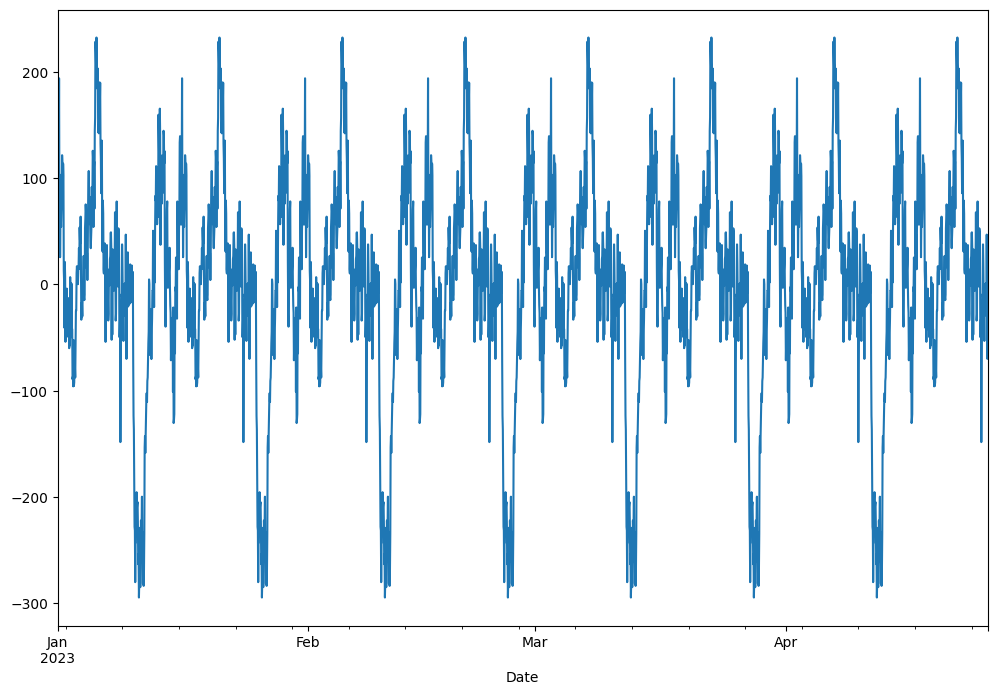

In [74]:
result.seasonal.plot()
# 특정 기간만 보기
plt.xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-04-26'))
plt.gcf().set_size_inches(12, 8)
plt.show()